# Time Series Analysis

- Use of sklearn time series analysis for forecasting
- Preprocess student data
- Split the data based on time periods
- Train the model
- Evaluate the model
- Tune the model
- Evalute the model
- Make forecast predictions

## Setup

In [1]:
# Standard Imports
import itertools
import logging
import random
from datetime import datetime

import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mango import Tuner, scheduler
from scipy.special import inv_boxcox
from scipy.stats import boxcox, uniform
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

/home/alan/miniconda3/envs/dissertation/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
color_pal = sns.color_palette("crest")

In [3]:
# Create Dask dashboard to visualise and track memory, CPU and GPU usage.
from dask.distributed import Client, LocalCluster

# Only show errors, surpress warnings
dask.config.set({"logging.distributed": "error"})
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit="2GB",
    silence_logs=logging.ERROR,
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44855,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:44257,Total threads: 2
Dashboard: http://127.0.0.1:34911/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:43829,


## Load Data

In [4]:
# Load the student data

# Load the cleaning summary of energy data
student_energy_summary = pd.read_csv(
    "../data/csv/student/missing_days_summary_v1.csv",
    index_col=False,
)

# Load cleaned student energy data
student_energy = dd.read_csv(
    "../data/csv/student/student_energy_cleaned_v1/*.part",
    index_col=False,
)
student_energy["recorded_timestamp"] = dd.to_datetime(
    student_energy["recorded_timestamp"]
)
# Exclusion dates
date_exclusion = pd.to_datetime("2016-12-31")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]

date_exclusion = pd.to_datetime("2018-12-31")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]
date_exclusion = pd.to_datetime("2019-01-01")
student_energy = student_energy[
    student_energy["recorded_timestamp"].dt.normalize() != date_exclusion
]

Since the SAVE dataset clearly states that the missing energy data for specific intervals is cumulatively added to the next valid
timestamp of energy usage. We can reverse this process using backwards cumulative disaggregation.

In [5]:
print(student_energy.columns)
print(student_energy.head())
print(student_energy_summary.head())

Index(['recorded_timestamp', 'bmg_id', 'energy'], dtype='object')
  recorded_timestamp       bmg_id  energy
0         2017-01-01  A1956617643     NaN
1         2017-01-02  A1956617643     NaN
2         2017-01-03  A1956617643     NaN
3         2017-01-04  A1956617643     NaN
4         2017-01-05  A1956617643     NaN
        bmg_id  missing_days_2017  longest_missing_streak_2017  \
0  A1956617643                 86                           43   
1  A1956623744                  0                            0   
2  A2956621093                256                          256   
3  A2956646445                  0                            0   
4  A4956611998                  0                            0   

   missing_days_2018  longest_missing_streak_2018  
0                364                          364  
1                248                          248  
2                153                          153  
3                  0                            0  
4                 99     

## Preprocess the data

- Filter the dataset to only those households with less than 5% missing data
- Use backward cumulative disaggregation

In [6]:
# Preprocess the data

"""
Filter the student energy dataset further to
only identify those household IDs with less than 5% missing data in both years.
"""
ids = student_energy_summary[
    (student_energy_summary["longest_missing_streak_2017"] <= 18)
    & (student_energy_summary["longest_missing_streak_2018"] <= 18)
]["bmg_id"]
print(len(ids))
print(ids)


def backfill_energy(df):
    df = df.sort_values("recorded_timestamp").reset_index(drop=True)

    energy = df["energy"].copy()
    result = energy.copy()

    i = 0
    while i < len(energy):
        if energy[i] == 0:
            start = i
            while i < len(energy) and (energy[i] == 0):
                i += 1
            if i < len(energy):
                count = i - start + 1
                average = energy[i] / count
                result[start : i + 1] = average
            else:
                result[start:] = np.nan
        else:
            i += 1

    df["energy"] = result
    return df[["bmg_id", "recorded_timestamp", "energy"]]


# Filter the student energy information
student_energy = student_energy[student_energy["bmg_id"].isin(ids)]

# Backfill the missing energy consumption data
student_energy = student_energy.groupby("bmg_id").apply(
    backfill_energy,
    meta={
        "bmg_id": "string",
        "recorded_timestamp": "datetime64[ns]",
        "energy": "float64",
    },
)

print(len(student_energy))

# These IDs have missing data towards the end of the time period and can therefore not be filled in any meaningful manner
# These need to be dropped.
missing_end_data = (
    student_energy[student_energy["energy"].isna()]["bmg_id"]
    .unique()
    .compute()
)

student_energy = student_energy[
    ~student_energy["bmg_id"].isin(missing_end_data)
]

print(len(student_energy))

127
3      A2956646445
10     A2956615457
11     A2956624999
12     A2956629166
18     A1956635837
          ...     
596    A1956630979
597    A2956630747
604    A1956659294
624    A1956640676
626    A2956642373
Name: bmg_id, Length: 127, dtype: object
92583
67797


 - Create a dataframe with the mean, median, min, max and std deviation energy values for all student households, for each day.

In [7]:
# Generate a dataframe with the energy statistics for all student households.

# Create a new dataframe with the energy consumption statistics
# for all student households

student_energy_statistics = pd.DataFrame()

student_energy_statistics = (
    student_energy.groupby(["recorded_timestamp"])
    .agg(
        **{
            "Mean Energy": pd.NamedAgg(column="energy", aggfunc="mean"),
            "Median Energy": pd.NamedAgg(column="energy", aggfunc="median"),
            "Min Energy": pd.NamedAgg(column="energy", aggfunc="min"),
            "Max Energy": pd.NamedAgg(column="energy", aggfunc="max"),
            "Std Energy": pd.NamedAgg(column="energy", aggfunc="std"),
        }
    )
    .compute()
    .reset_index()
)

student_energy_statistics["recorded_timestamp"] = pd.to_datetime(
    student_energy_statistics["recorded_timestamp"]
)
student_energy_statistics = student_energy_statistics.set_index(
    "recorded_timestamp"
)
student_energy_statistics = student_energy_statistics.sort_index()

## Understand the data
- Visualise the time series data to understand the trend and seasonality
    - Visualise and understand a random sample
    - Visualise and understand the median use value
- Use the ADF test for stationarity
    - Based on this, decide the time-series model to be used
    - Based on this, decide the trend and seasonality inferences

In [8]:
def check_stationarity(s):
    adf, pval, _, _, crit_vals, _ = adfuller(s)

    print(f"ADF statisic: {adf}")
    print(f"p-value: {pval}")
    for k, v in crit_vals.items():
        print(f"\t{k}: {v}")

    if (pval < 0.05) and (crit_vals["5%"] > adf):
        print("The time series is stationary")
    else:
        print("The time series is NOT stationary")

### All student households

In [9]:
print("\nEnergy Statistic\n")
print(student_energy_statistics.info())
print(student_energy_statistics.head())
print(student_energy_statistics.describe())
print()
check_stationarity(student_energy_statistics["Median Energy"])


Energy Statistic

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2017-01-01 to 2018-12-30
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Mean Energy    729 non-null    float64
 1   Median Energy  729 non-null    float64
 2   Min Energy     729 non-null    float64
 3   Max Energy     729 non-null    float64
 4   Std Energy     729 non-null    float64
dtypes: float64(5)
memory usage: 34.2 KB
None
                    Mean Energy  Median Energy  Min Energy  Max Energy  \
recorded_timestamp                                                       
2017-01-01            15.777495         13.726      1.8270      65.793   
2017-01-02            16.283398         13.829      2.4090      65.793   
2017-01-03            15.557602         12.133      2.0260      90.475   
2017-01-04            15.028081         11.848      0.0005      73.929   
2017-01-05            15.130919         11.424      0.0005  

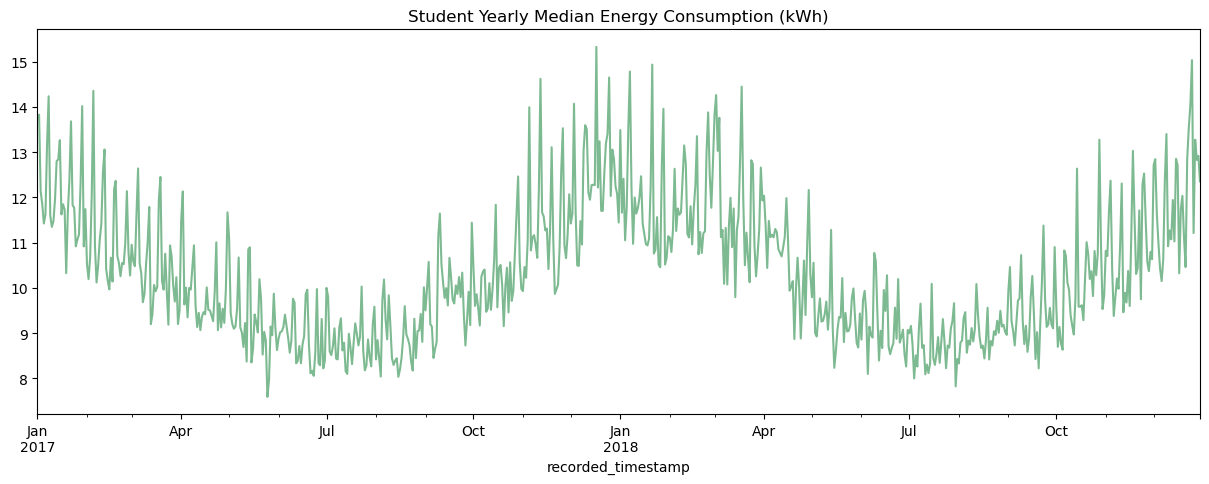

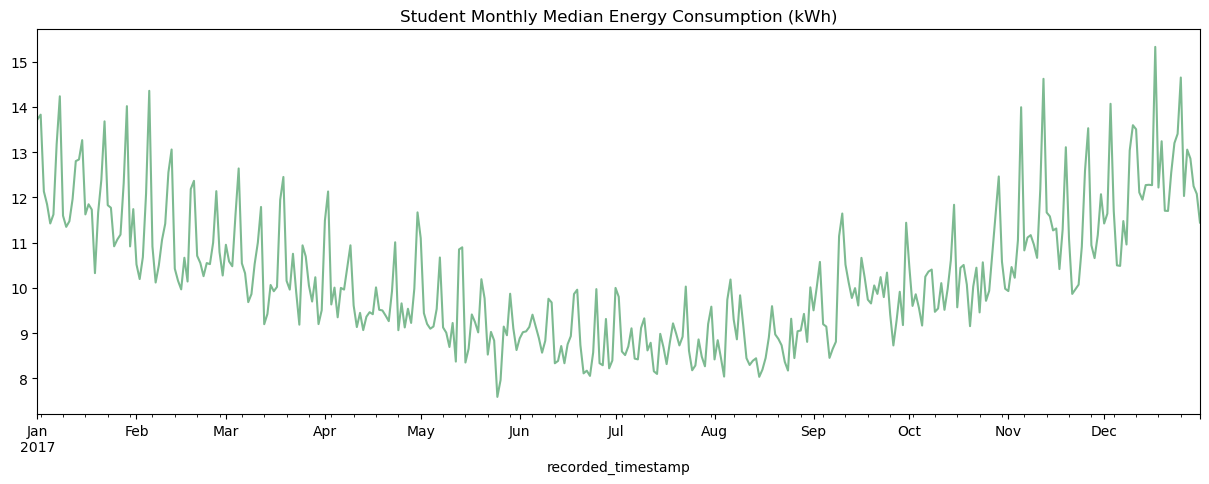

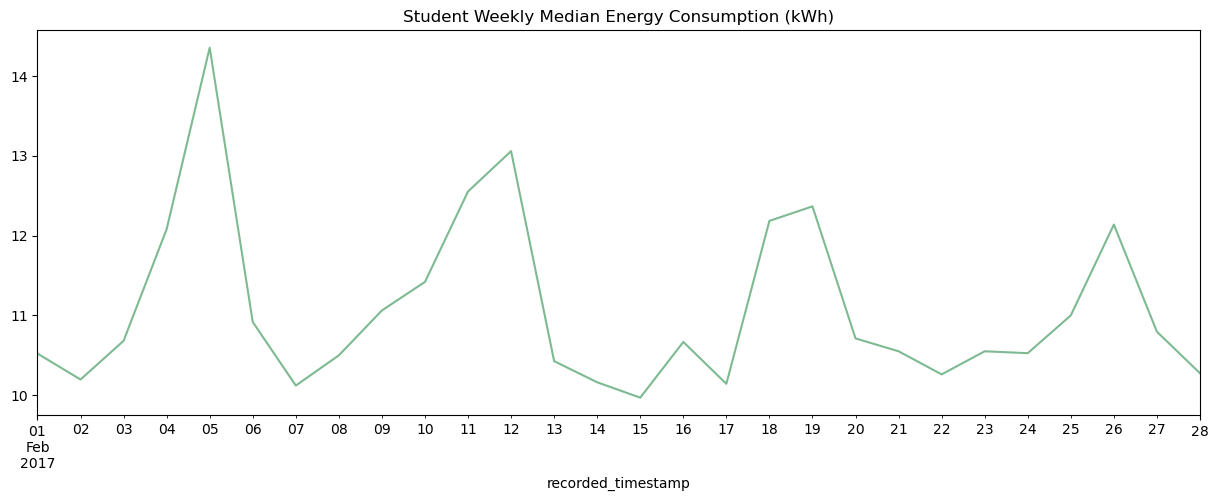

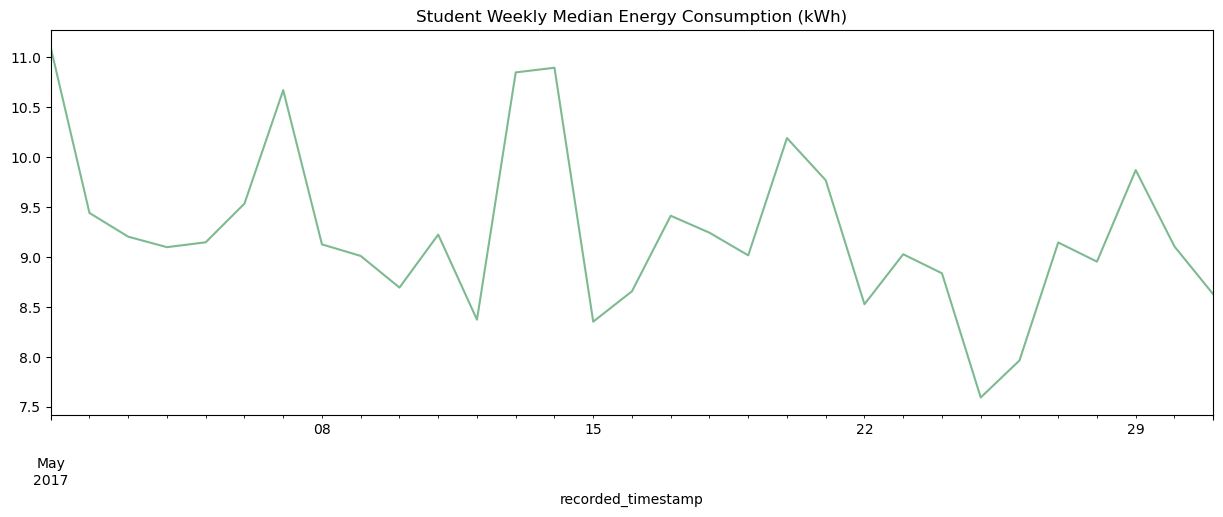

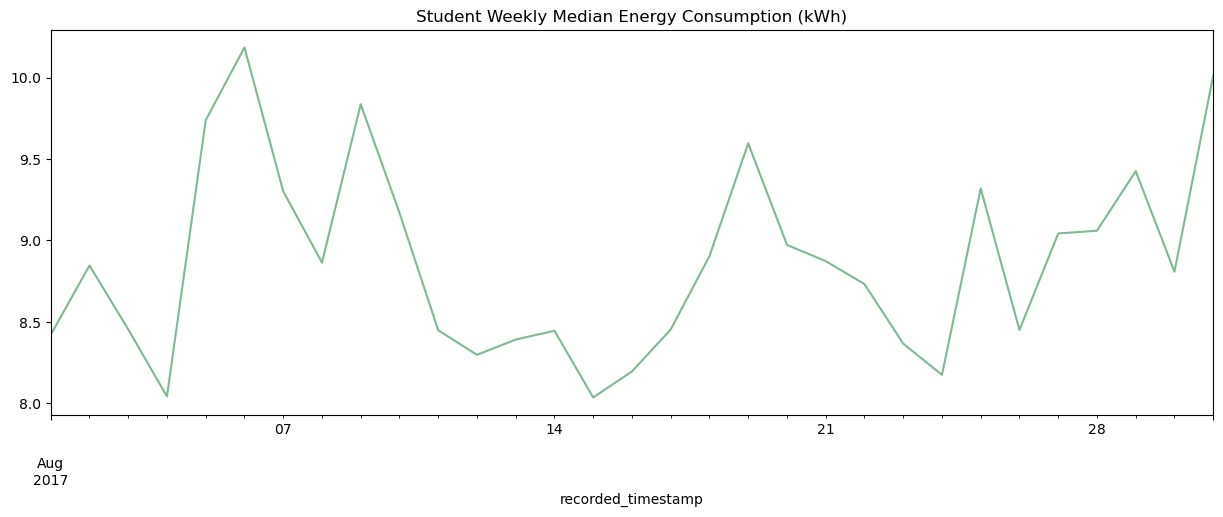

In [10]:
# Visualise the student Median Energy usage over 2017 and 2018
student_energy_statistics["Median Energy"].plot(
    figsize=(15, 5),
    color=color_pal,
    title="Student Yearly Median Energy Consumption (kWh)",
)
plt.show()

# Visualise the Median Energy use in just one year
student_energy_statistics.loc["2017"]["Median Energy"].plot(
    figsize=(15, 5),
    color=color_pal,
    title="Student Monthly Median Energy Consumption (kWh)",
)
plt.show()

# Visualise the Median Energy use in just one month
student_energy_statistics.loc["2017-02"]["Median Energy"].plot(
    figsize=(15, 5),
    color=color_pal,
    title="Student Weekly Median Energy Consumption (kWh)",
)
plt.show()

# Visualise the Median Energy use in just one month
student_energy_statistics.loc["2017-05"]["Median Energy"].plot(
    figsize=(15, 5),
    color=color_pal,
    title="Student Weekly Median Energy Consumption (kWh)",
)
plt.show()

# Visualise the Median Energy use in just one month
student_energy_statistics.loc["2017-08"]["Median Energy"].plot(
    figsize=(15, 5),
    color=color_pal,
    title="Student Weekly Median Energy Consumption (kWh)",
)
plt.show()

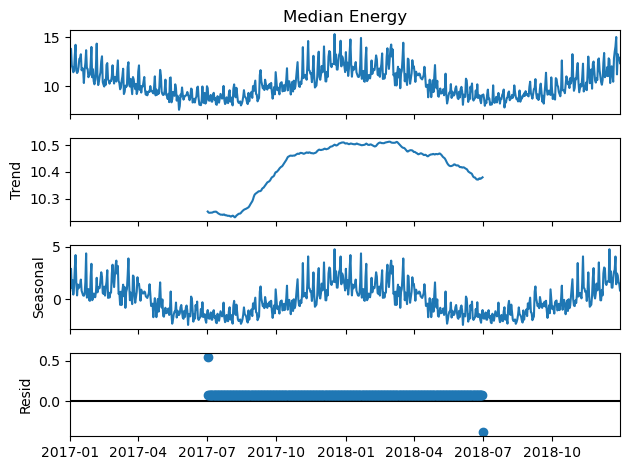

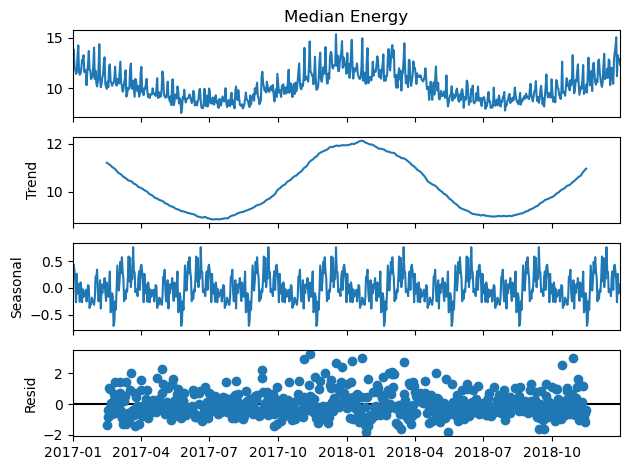

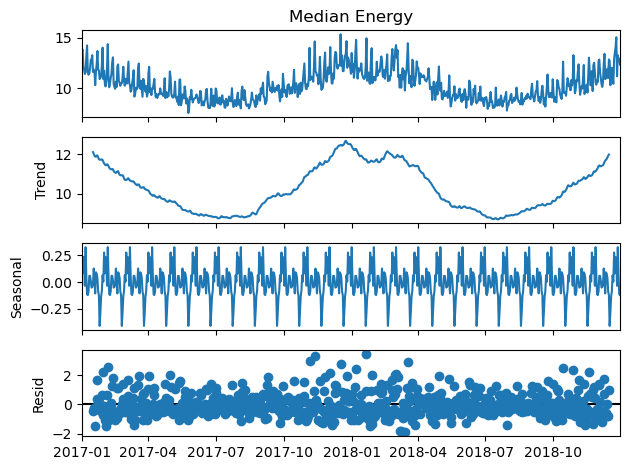

In [11]:
# Seasonal Decomposition
decomposition = seasonal_decompose(
    student_energy_statistics["Median Energy"], model="additive", period=364
)
decomposition.plot()
plt.show()

decomposition = seasonal_decompose(
    student_energy_statistics["Median Energy"], model="additive", period=90
)
decomposition.plot()
plt.show()

decomposition = seasonal_decompose(
    student_energy_statistics["Median Energy"], model="additive", period=30
)
decomposition.plot()
plt.show()

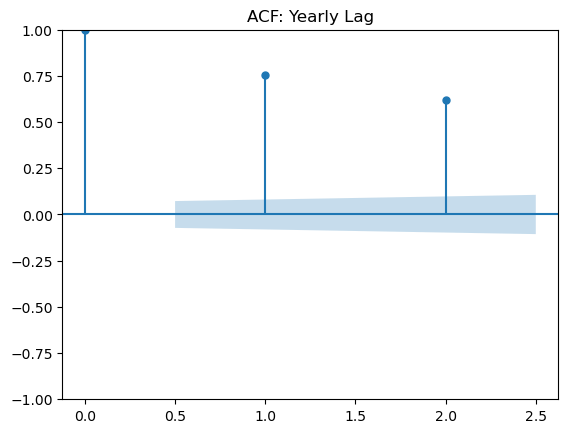

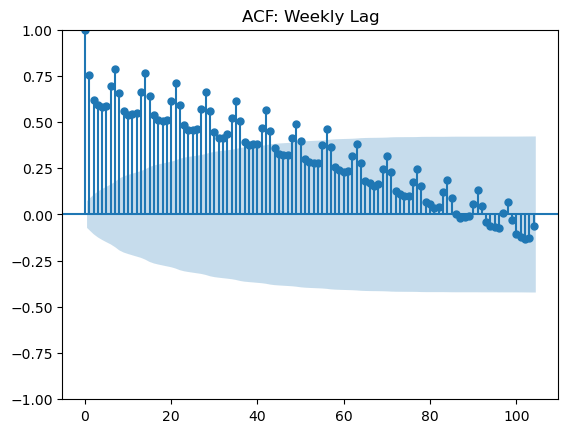

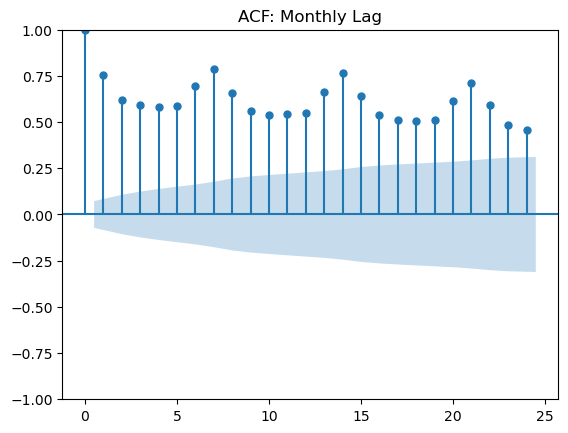

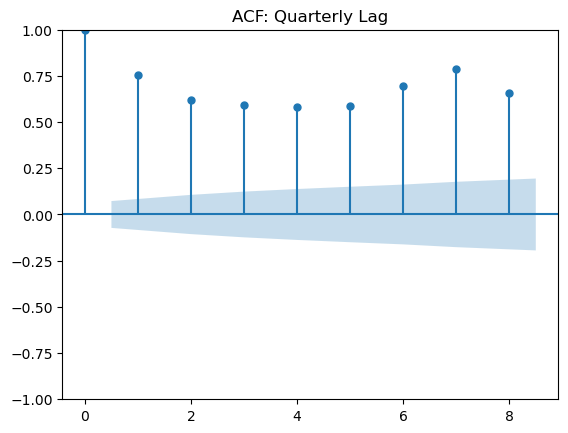

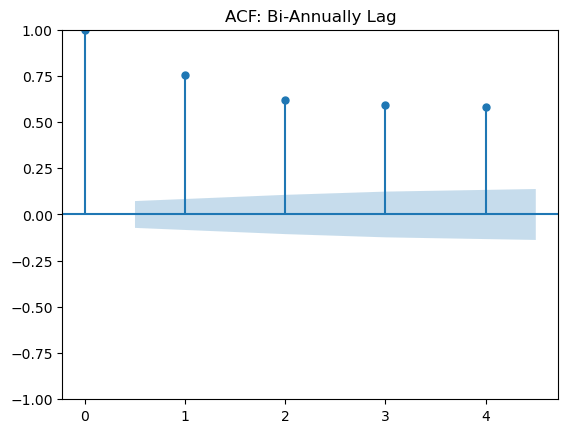

In [12]:
# Visualise ACF
# Yearly lags
_ = plot_acf(
    student_energy_statistics["Median Energy"], lags=2, title="ACF: Yearly Lag"
)

# Weekly lags
_ = plot_acf(
    student_energy_statistics["Median Energy"],
    lags=104,
    title="ACF: Weekly Lag",
)

# Monthly lags
_ = plot_acf(
    student_energy_statistics["Median Energy"],
    lags=24,
    title="ACF: Monthly Lag",
)

# Quarterly
_ = plot_acf(
    student_energy_statistics["Median Energy"],
    lags=8,
    title="ACF: Quarterly Lag",
)

# Half-Yearly
_ = plot_acf(
    student_energy_statistics["Median Energy"],
    lags=4,
    title="ACF: Bi-Annually Lag",
)

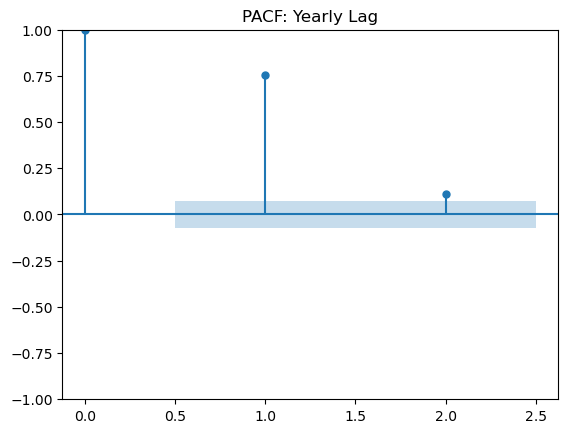

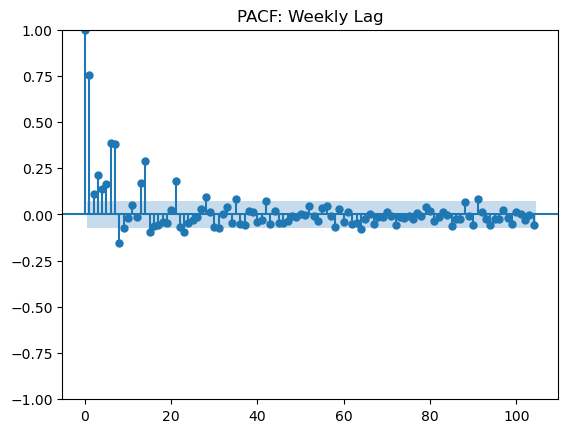

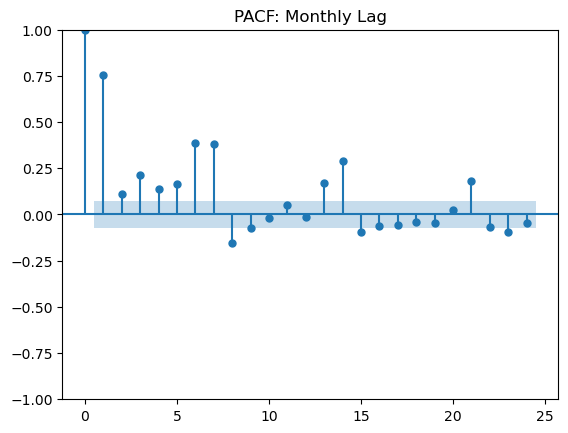

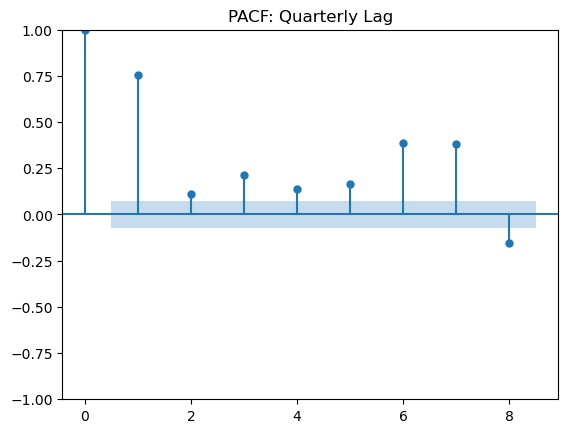

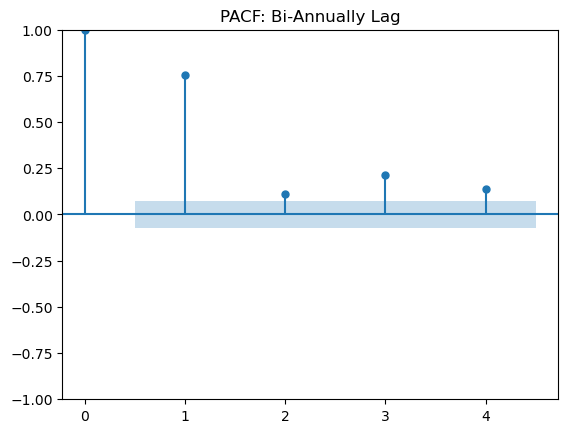

In [13]:
# Visualise PACF
# Yearly lags
_ = plot_pacf(
    student_energy_statistics["Median Energy"],
    lags=2,
    title="PACF: Yearly Lag",
)

# Weekly lags
_ = plot_pacf(
    student_energy_statistics["Median Energy"],
    lags=104,
    title="PACF: Weekly Lag",
)

# Monthly lags
_ = plot_pacf(
    student_energy_statistics["Median Energy"],
    lags=24,
    title="PACF: Monthly Lag",
)

# Quarterly
_ = plot_pacf(
    student_energy_statistics["Median Energy"],
    lags=8,
    title="PACF: Quarterly Lag",
)

# Half-Yearly
_ = plot_pacf(
    student_energy_statistics["Median Energy"],
    lags=4,
    title="PACF: Bi-Annually Lag",
)

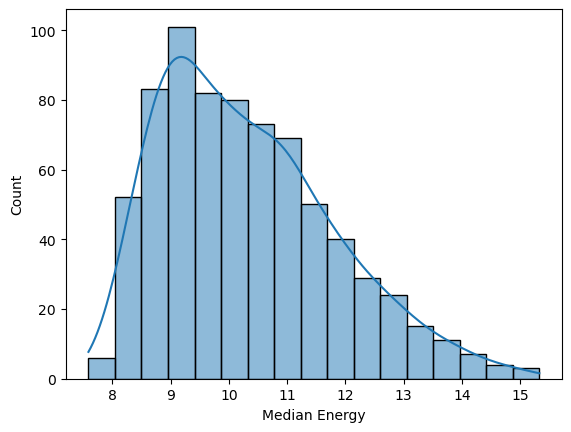

In [14]:
sns.histplot(student_energy_statistics["Median Energy"], kde=True)
plt.show()

### Single random sample

In [15]:
# Create sample data
# The goal here is to train the model using one student, for student-specific behaviour.
# Isolate one random student household to train the model
group_ids = student_energy["bmg_id"].unique().compute()
random_id = random.choice(group_ids.tolist())

student_energy_sample = student_energy[
    student_energy["bmg_id"] == random_id
].compute()

# Set the index to the datetime value.
student_energy_sample["recorded_timestamp"] = pd.to_datetime(
    student_energy_sample["recorded_timestamp"]
)
student_energy_sample = student_energy_sample.set_index("recorded_timestamp")
student_energy_sample = student_energy_sample.sort_index()

In [16]:
print("\nSample Energy Information\n")
print(student_energy_sample.head())
print(student_energy_sample.info())
print(student_energy_sample.describe())
print()
check_stationarity(student_energy_sample["energy"])


Sample Energy Information

                         bmg_id  energy
recorded_timestamp                     
2017-01-01          A2956626330  12.901
2017-01-02          A2956626330  10.813
2017-01-03          A2956626330  11.725
2017-01-04          A2956626330  10.501
2017-01-05          A2956626330  11.264
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2017-01-01 to 2018-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bmg_id  729 non-null    string 
 1   energy  729 non-null    float64
dtypes: float64(1), string(1)
memory usage: 24.9 KB
None
           energy
count  729.000000
mean     9.059446
std      2.171928
min      2.698000
25%      7.597000
50%      8.703000
75%     10.223000
max     21.380000

ADF statisic: -2.2717255352887875
p-value: 0.18124923734804355
	1%: -3.439620010600208
	5%: -2.8656309041017756
	10%: -2.5689484851894413
The time series is NOT stationary


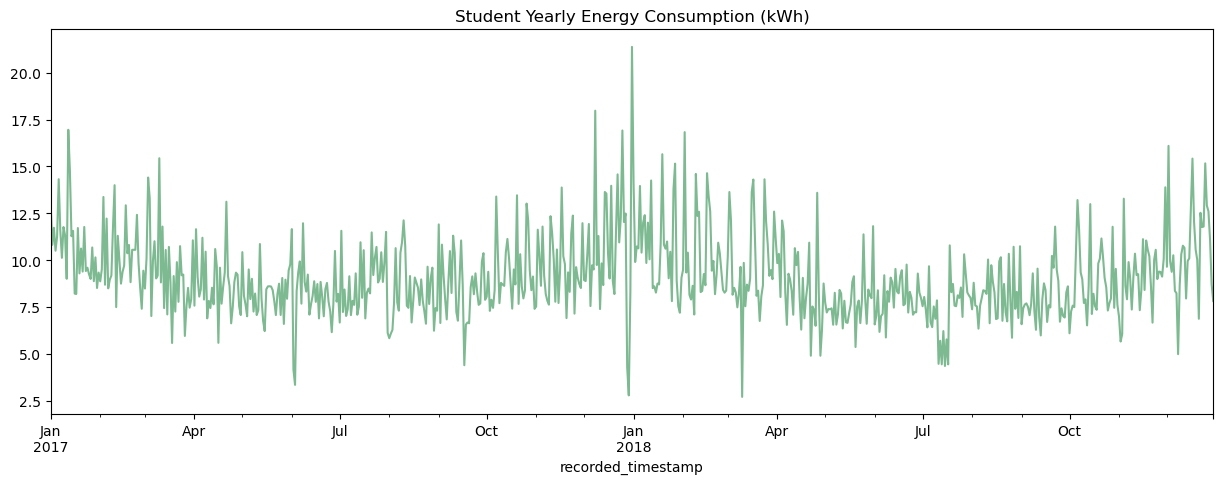

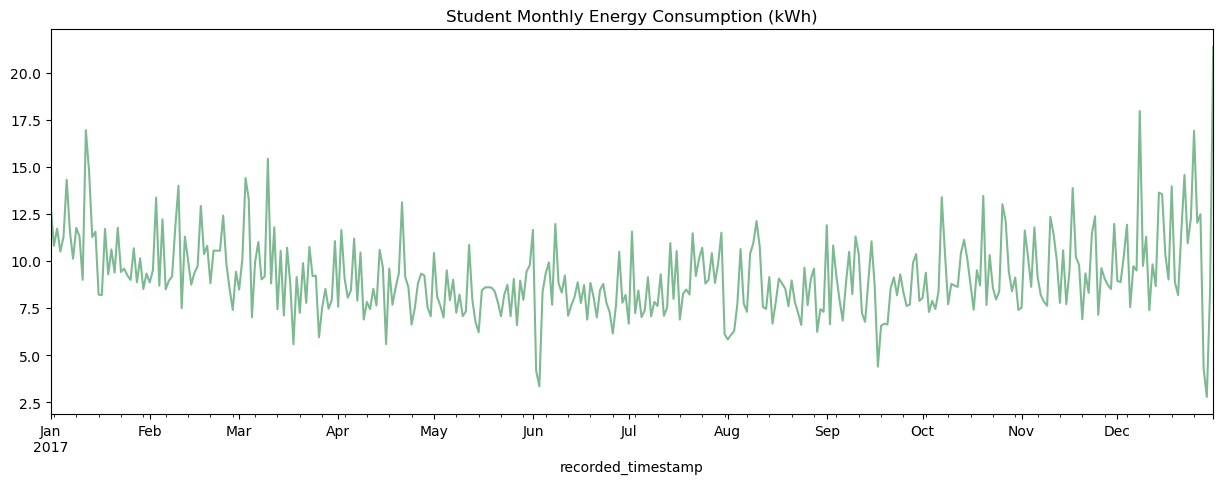

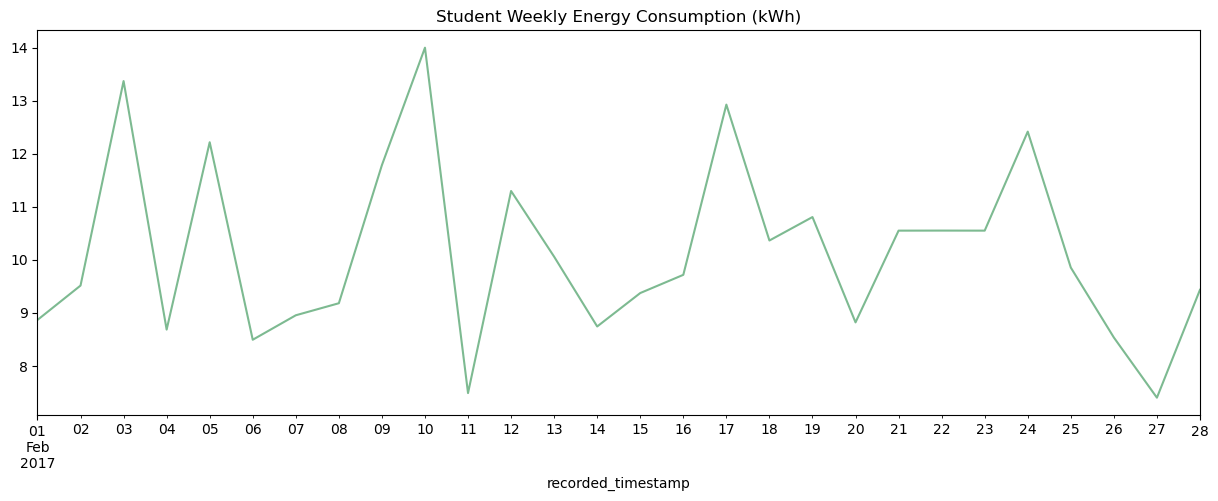

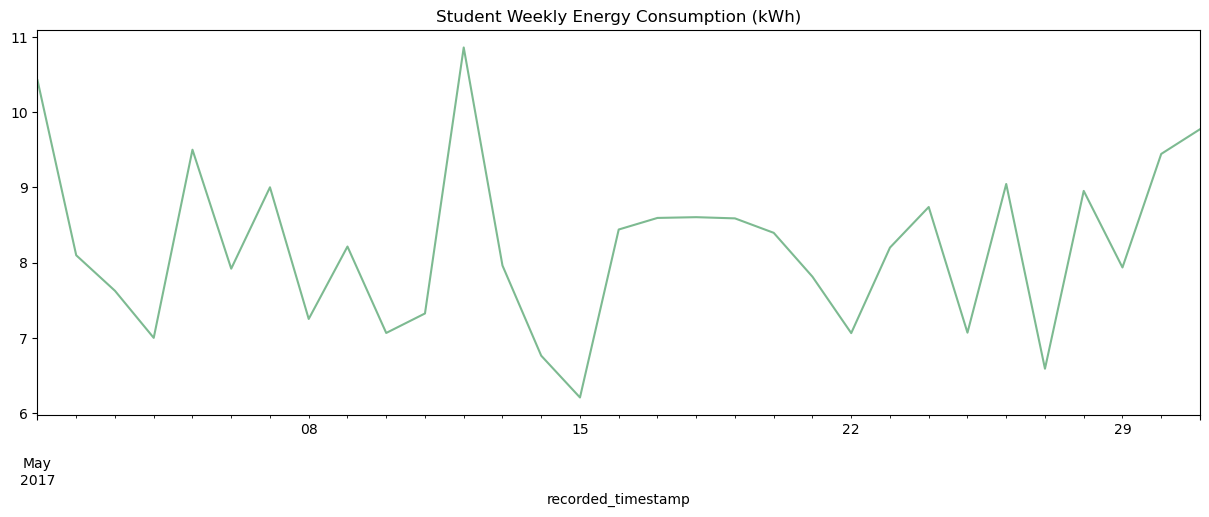

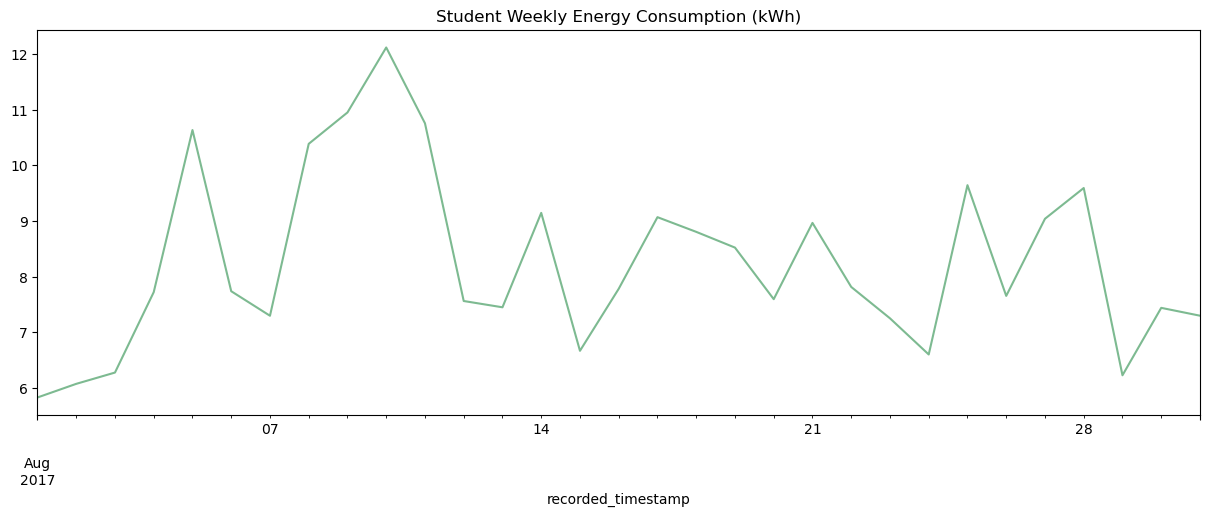

In [17]:
# Visualise the student energy usage over 2017 and 2018
student_energy_sample["energy"].plot(
    figsize=(15, 5),
    color=color_pal[0],
    title="Student Yearly Energy Consumption (kWh)",
)
plt.show()

# Visualise the energy use in just one year
student_energy_sample.loc["2017"]["energy"].plot(
    figsize=(15, 5),
    color=color_pal[0],
    title="Student Monthly Energy Consumption (kWh)",
)
plt.show()

# Visualise the energy use in just one month
student_energy_sample.loc["2017-02"]["energy"].plot(
    figsize=(15, 5),
    color=color_pal[0],
    title="Student Weekly Energy Consumption (kWh)",
)
plt.show()

# Visualise the energy use in just one month
student_energy_sample.loc["2017-05"]["energy"].plot(
    figsize=(15, 5),
    color=color_pal[0],
    title="Student Weekly Energy Consumption (kWh)",
)
plt.show()

# Visualise the energy use in just one month
student_energy_sample.loc["2017-08"]["energy"].plot(
    figsize=(15, 5),
    color=color_pal[0],
    title="Student Weekly Energy Consumption (kWh)",
)
plt.show()

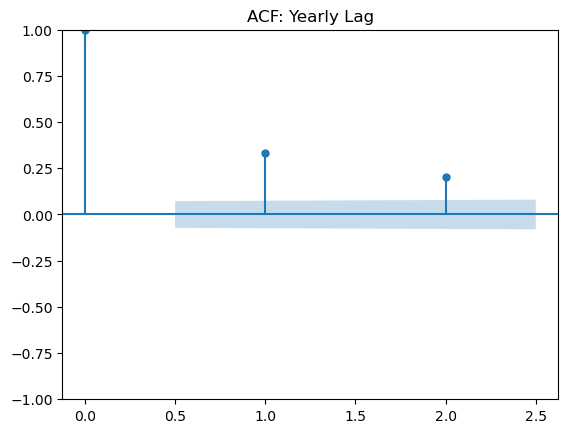

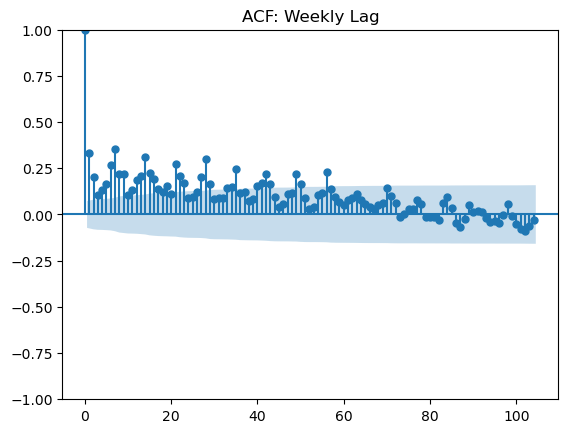

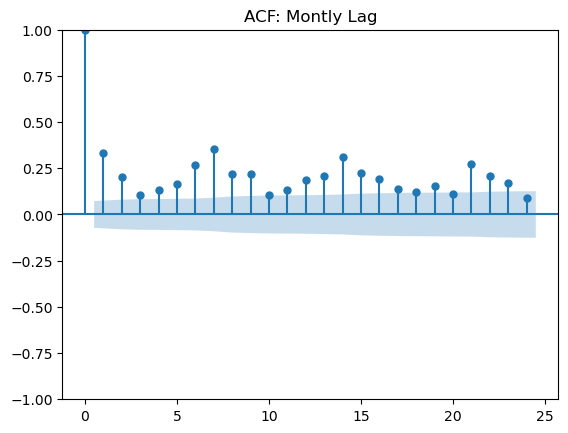

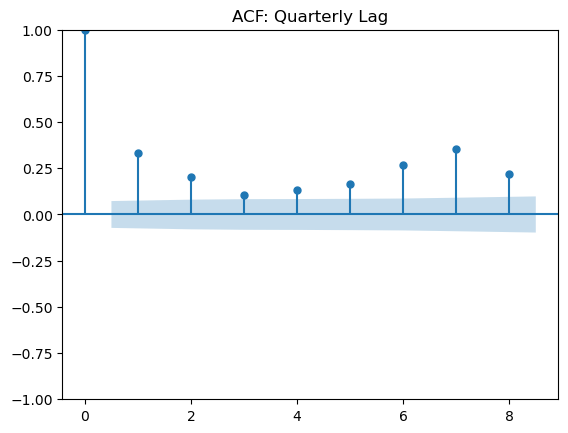

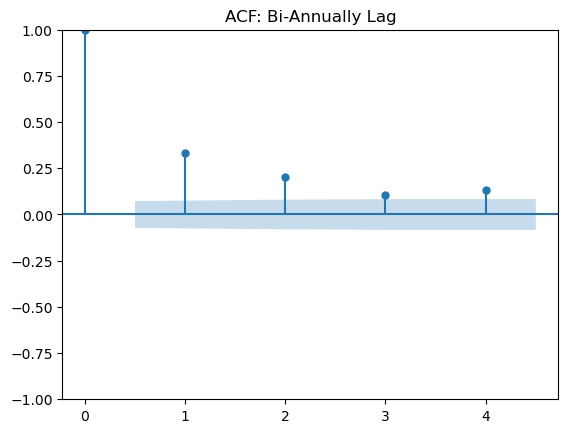

In [18]:
# Visualise ACF
# Yearly lags
_ = plot_acf(student_energy_sample["energy"], lags=2, title="ACF: Yearly Lag")

# Weekly lags
_ = plot_acf(
    student_energy_sample["energy"], lags=104, title="ACF: Weekly Lag"
)

# Monthly lags
_ = plot_acf(student_energy_sample["energy"], lags=24, title="ACF: Montly Lag")

# Quarterly
_ = plot_acf(
    student_energy_sample["energy"], lags=8, title="ACF: Quarterly Lag"
)

# Half-Yearly
_ = plot_acf(
    student_energy_sample["energy"], lags=4, title="ACF: Bi-Annually Lag"
)

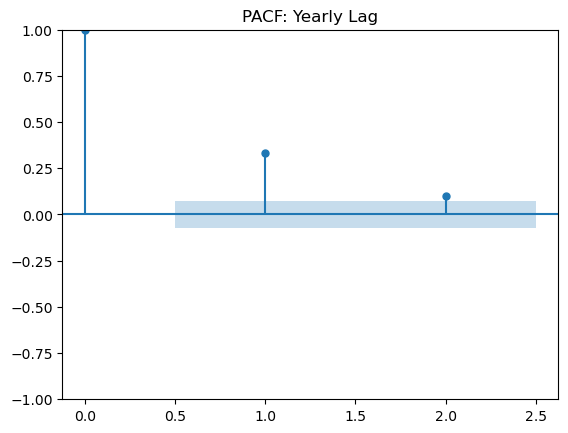

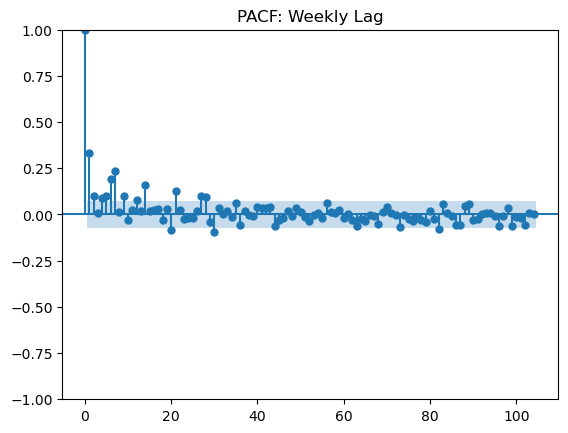

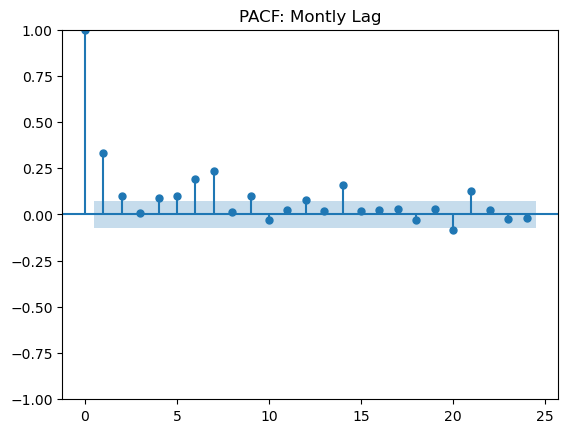

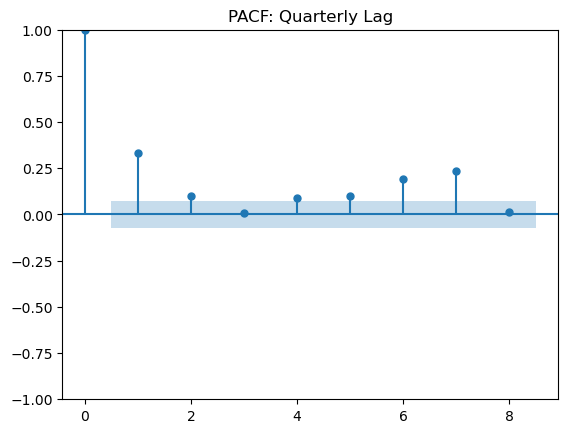

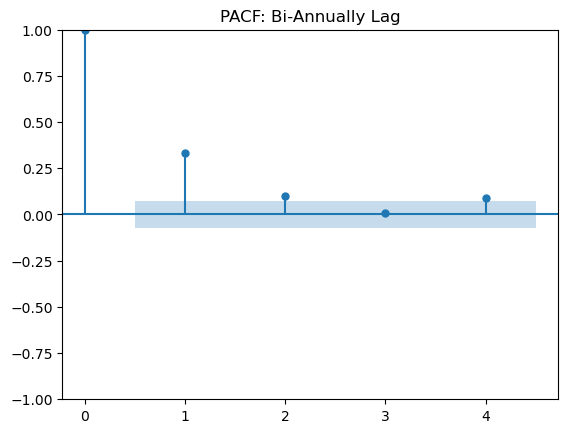

In [19]:
# Visualise PACF
# Yearly lags
_ = plot_pacf(
    student_energy_sample["energy"], lags=2, title="PACF: Yearly Lag"
)

# Weekly lags
_ = plot_pacf(
    student_energy_sample["energy"], lags=104, title="PACF: Weekly Lag"
)

# Monthly lags
_ = plot_pacf(
    student_energy_sample["energy"], lags=24, title="PACF: Montly Lag"
)

# Quarterly
_ = plot_pacf(
    student_energy_sample["energy"], lags=8, title="PACF: Quarterly Lag"
)

# Half-Yearly
_ = plot_pacf(
    student_energy_sample["energy"], lags=4, title="PACF: Bi-Annually Lag"
)

## Model Selection

Since the current data shows seasonality across overlapping periods:
- Weeks
- Months
- Quarters

The selected model must be able to handle these intricacies and variances.
As such, there are only two major models that work well with TSA that have seasonality:

- SARIMA
- Prophet
- TBATS
   
Considering the overlapping seasonality, Prophet is a better choice (it is specifically developed for this purpose).

In [20]:
import warnings

import cmdstanpy
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_from_json, model_to_json

warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter(
    "ignore",
    FutureWarning,
)
logging.getLogger("prophet").setLevel(logging.ERROR)

Importing plotly failed. Interactive plots will not work.


## Feature Engineering

The Prophet model requires only two Series as inputs, formatted to the Pandas DataFrame structure.
For this reason, we must strip the `student_energy_statistcs` DataFrame of values apart from `recorded_timestamp`, renamed as `ds`, and `Median Energy`, renamed as `y`.

The same transformation will be done for the single household sample as well.

In [21]:
student_energy_median = student_energy_statistics["Median Energy"]
student_energy_median = student_energy_median.reset_index()
student_energy_median = student_energy_median.rename(
    columns={"recorded_timestamp": "ds", "Median Energy": "y"}
)
student_energy_median

,ds,y
0,2017-01-01,13.726
1,2017-01-02,13.829
2,2017-01-03,12.133
3,2017-01-04,11.848
4,2017-01-05,11.424
...,...,...
724,2018-12-26,11.211
725,2018-12-27,13.275
726,2018-12-28,12.828
727,2018-12-29,12.917


## Model specific transforms

- Since energy data has high variance across seasons, we need to normalise this.
- Box cox transforms are used for this purpose

In [22]:
student_energy_median["y"], lmbda = boxcox(student_energy_median["y"])
print(lmbda)
print(student_energy_median.head())

-1.417052883030694
          ds         y
0 2017-01-01  0.688445
1 2017-01-02  0.688627
2 2017-01-03  0.685151
3 2017-01-04  0.684448
4 2017-01-05  0.683322


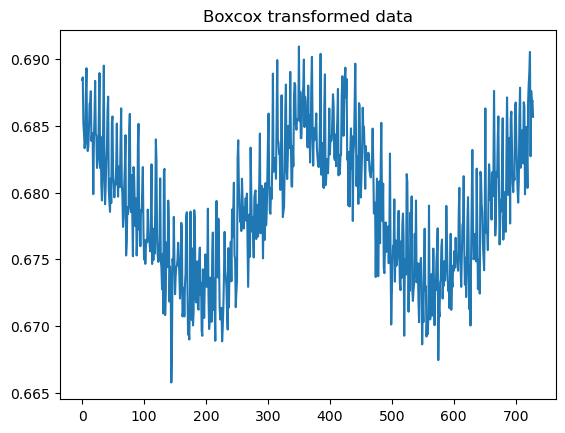

In [23]:
fig, ax = plt.subplots()
ax.set_title("Boxcox transformed data")
student_energy_median["y"].plot(ax=ax)
plt.show()

## Model Training

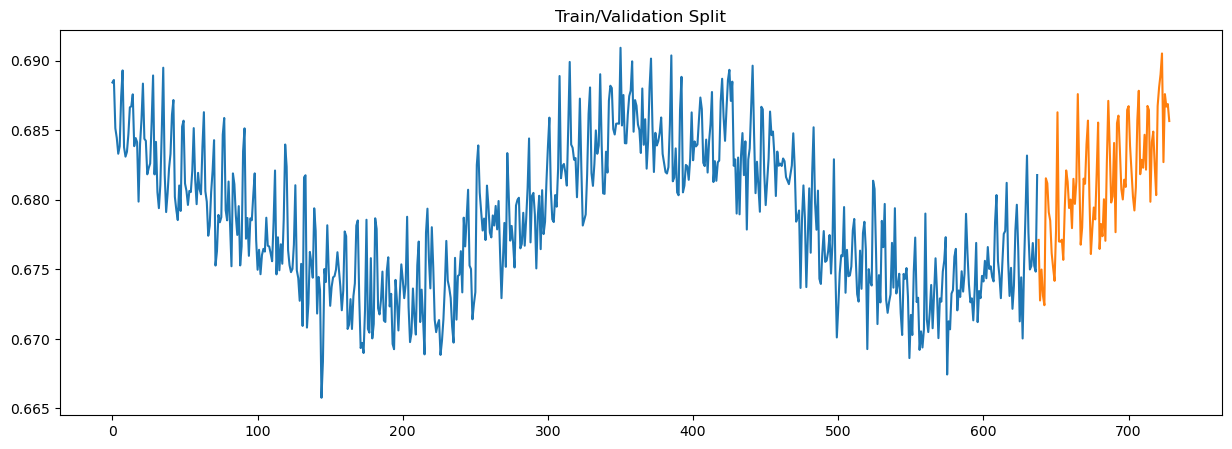

In [24]:
# Split the data based on the timestamp
# For a meaningful split we need atleast 1.5 years of data
# For an 80:20 split we need 20 months to train and 4 months to test
train = student_energy_median[student_energy_median["ds"] < "10-01-2018"]
validate = student_energy_median[student_energy_median["ds"] >= "10-01-2018"]

# Visualise the split
fix, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Train/Validation Split")
train["y"].plot(ax=ax, label="Training Data")
validate["y"].plot(ax=ax, label="Validation Data")
plt.show()

In [25]:
# Create and train the model
model = Prophet(
    daily_seasonality=False,
    changepoint_prior_scale=0.7659059237577944,
    changepoint_range=0.7205198827375914,
    seasonality_prior_scale=9.367978597849588,
    interval_width=0.808510265022176,
    growth="linear",
    n_changepoints=25,
)
model.add_seasonality(name="weekly", period=7, fourier_order=2)
model.add_seasonality(name="monthly", period=30.5, fourier_order=3)
#model.add_seasonality(name="quarterly", period=91.25, fourier_order=6)
model.add_seasonality(name="yearly", period=365, fourier_order=10)

model.fit(train)

14:34:08 - cmdstanpy - INFO - Chain [1] start processing
14:34:08 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# Save the model
with open(
    "../models/median_model_base_"
    + datetime.now().strftime("%Y-%m-%d::%H:%M:%S")
    + ".json",
    "w",
) as fout:
    fout.write(model_to_json(model))

## Model Evaluation
- Evaluation of base model
- Understanding the feature importance
- Understanding the model

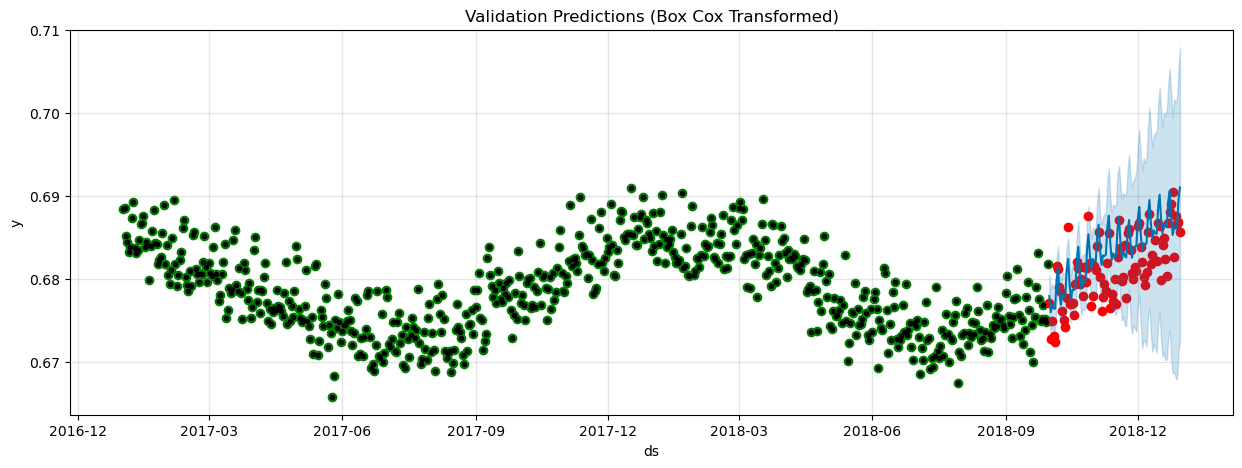

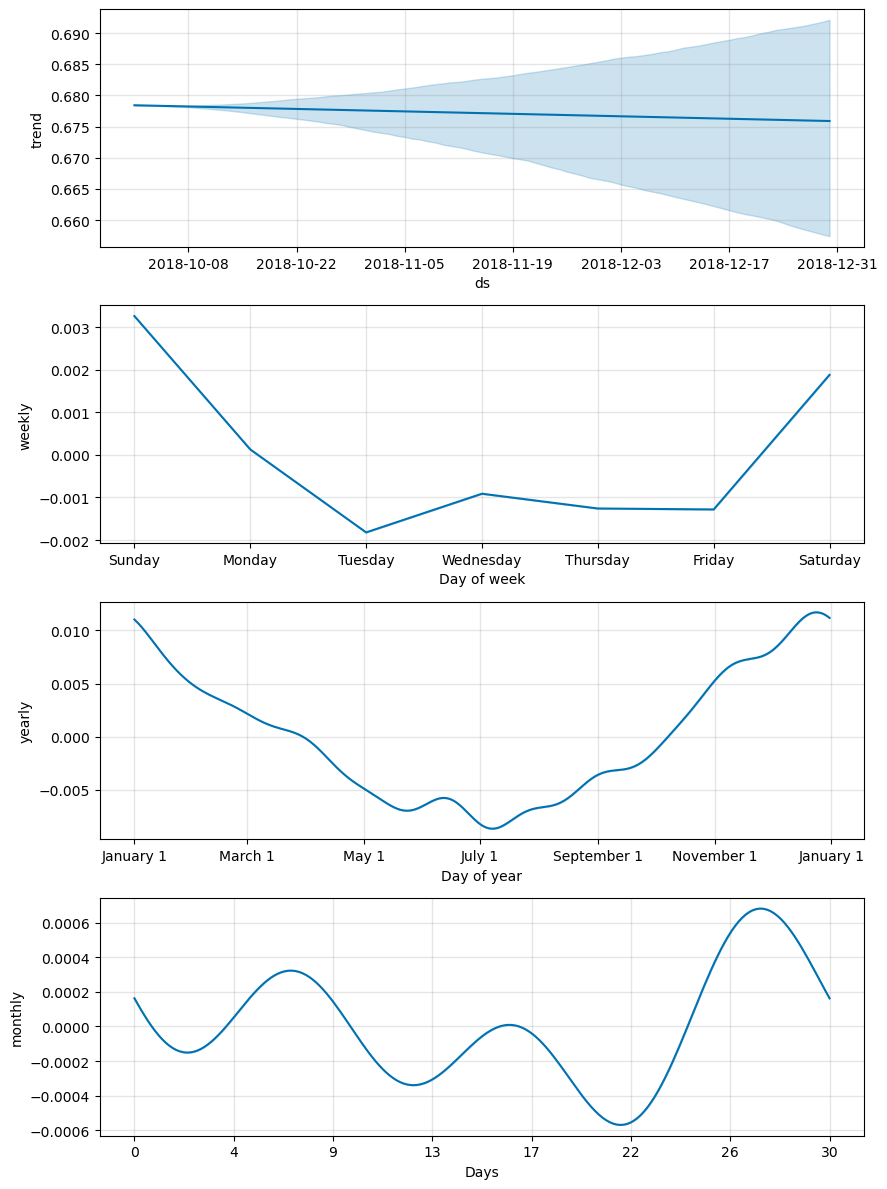

In [27]:
# Make a prediction
future = model.make_future_dataframe(
    periods=90, freq="D", include_history=False
)


predictions = model.predict(validate)

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Validation Predictions (Box Cox Transformed)")
ax.scatter(train["ds"], train["y"], color="green")
ax.scatter(validate["ds"], validate["y"], color="red")
model.plot(predictions, ax=ax)
plt.show()

_ = model.plot_components(predictions)
plt.show()

In [28]:
predictions[["yhat", "yhat_upper", "yhat_lower"]] = predictions[
    ["yhat", "yhat_upper", "yhat_lower"]
].apply(lambda x: inv_boxcox(x, lmbda))
validate["y"] = inv_boxcox(validate["y"], lmbda)
print(predictions["yhat"].head())
print(validate["y"].head())

0    9.818166
1    9.360894
2    9.552681
3    9.456756
4    9.453535
Name: yhat, dtype: float64
638    9.613
639    8.697
640    9.137
641    8.761
642    8.634
Name: y, dtype: float64


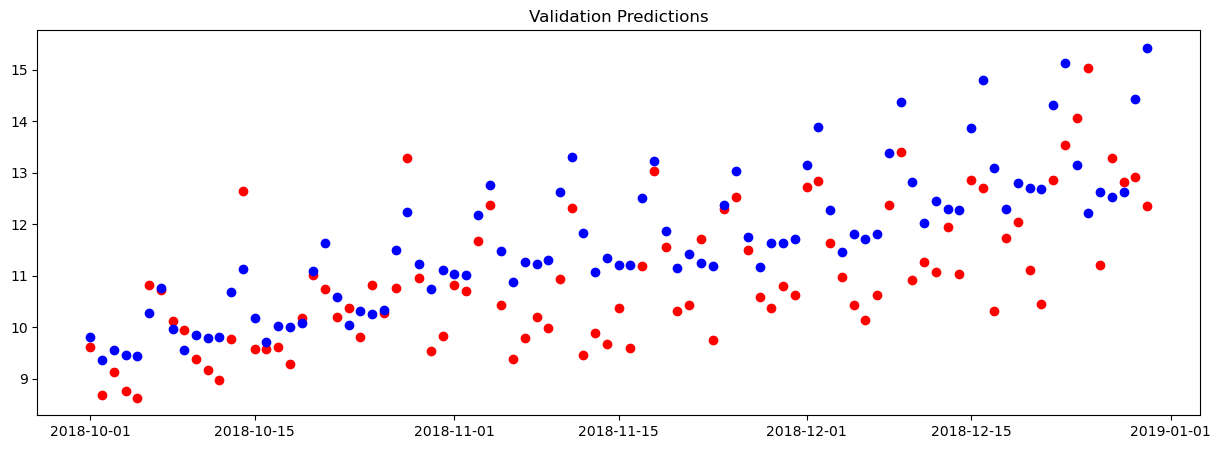

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Validation Predictions")
ax.scatter(validate["ds"], validate["y"], color="red")
ax.scatter(predictions["ds"], predictions["yhat"], color="blue")
plt.show()

In [30]:
print(mean_squared_error(y_true=validate["y"], y_pred=predictions["yhat"]))

1.278654396746765


In [31]:
print(
    mean_absolute_percentage_error(
        y_true=validate["y"], y_pred=predictions["yhat"]
    )
    * 100
)

8.558187832225068


In [32]:
print(
    root_mean_squared_error(y_true=validate["y"], y_pred=predictions["yhat"])
)

1.1307760152863011


## Model Tuning
- Tune the hyperparameters
  - changepoint_prior_scale: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular, how much the trend changes at the trend change points. Range of [0.001, 0.5]. To be tuned using a log scale. Equivalent to the L1 penalty of ridge regression.
  - seasonality_prior_scale: This parameter controls the flexibility of the seasonality. A reasonable range for tuning it would probably be [0.01, 10]. To be tuned using a log scale. Equivalent to the L2 penalty of ridge regression.
  - changepoint_range: This is the proportion of the history in which the trend is allowed to change.  In that setting, [0.8, 0.95] may be a reasonable range.
- Cross-validation to assess prediction performance over the horizon of 60 days. 
- Retrain the model
    - This generates the final tuned model    

In [47]:
# Hyperparameter tuning
param_grid = {
    "changepoint_prior_scale": np.geomspace(0.01, 0.5, num=10, endpoint=True),
    "seasonality_prior_scale": np.geomspace(0.01, 10, num=10, endpoint=True),
    "changepoint_range": np.linspace(0.8, 0.95, num=3, endpoint=True),
}

all_params = [
    dict(zip(param_grid.keys(), v))
    for v in itertools.product(*param_grid.values())
]
mape = []
rmse = []

for param in all_params:
    m = Prophet(
        daily_seasonality=False, interval_width=0.95, growth="linear", **param
    )
    m.add_seasonality(name="weekly", period=7, fourier_order=2)
    m.add_seasonality(name="monthly", period=30.5, fourier_order=1)
    m.add_seasonality(name="quarterly", period=91.25, fourier_order=2)
    m.add_seasonality(name="yearly", period=365, fourier_order=6)
    m = m.fit(student_energy_median)
    cross_validation_df = cross_validation(
        m, initial="365 days", horizon="90 days", parallel="dask"
    )
    performance_df = performance_metrics(
        cross_validation_df,
        metrics=["mape", "rmse", "mdape"],
        rolling_window=1,
    )
    mape.append(performance_df["mape"].values[0])
    rmse.append(performance_df["rmse"].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results["mape"] = mape
tuning_results["rmse"] = rmse
print(tuning_results)
tuning_results.to_csv(
    "../models/hyperparametertuning_median"
    + datetime.now().strftime("%Y-%m-%d::%H:%M:%S")
    + ".csv"
)

best_params = all_params[np.argmin(mape)]
print(best_params)

best_params = all_params[np.argmin(rmse)]
print(best_params)

17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1]

     changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                       0.01                 0.010000              0.800   
1                       0.01                 0.010000              0.875   
2                       0.01                 0.010000              0.950   
3                       0.01                 0.021544              0.800   
4                       0.01                 0.021544              0.875   
..                       ...                      ...                ...   
295                     0.50                 4.641589              0.875   
296                     0.50                 4.641589              0.950   
297                     0.50                10.000000              0.800   
298                     0.50                10.000000              0.875   
299                     0.50                10.000000              0.950   

         mape      rmse  
0    0.079314  0.986720  
1    0.077916  0.963008  
2    0.07

In [33]:
# Model Tuning Using Mango
student_energy_median = student_energy_statistics["Median Energy"]
student_energy_median = student_energy_median.reset_index()
student_energy_median = student_energy_median.rename(
    columns={"recorded_timestamp": "ds", "Median Energy": "y"}
)

student_energy_median["y"], lmbda = boxcox(student_energy_median["y"])

train = student_energy_median[student_energy_median["ds"] < "10-01-2018"]
validate = student_energy_median[student_energy_median["ds"] >= "10-01-2018"]

param_space = dict(
    growth=["linear", "logarithmic", "flat"],
    n_changepoints=range(0, 100, 5),
    changepoint_range=uniform(0.5, 0.5),
    yearly_seasonality=[True, False],
    weekly_seasonality=[True, False],
    seasonality_mode=[
        "additive",
    ],
    seasonality_prior_scale=uniform(1, 10.0),
    changepoint_prior_scale=uniform(0.0, 1),
    interval_width=uniform(0.8, 0.15),
    # quarterly_seasonality=[True, False],
    monthly_seasonality=[True, False],
)


def parameter_tuning(args_list):
    global train, validate

    params_evaluated = []
    results = []

    for params in args_list:
        try:
            model_params = params.copy()
            model_params.pop("monthly_seasonality")
            # model_params.pop("quarterly_seasonality")
            model = Prophet(**model_params)
            if params["weekly_seasonality"]:
                model.add_seasonality(name="weekly", period=7, fourier_order=2)
            if params["monthly_seasonality"]:
                model.add_seasonality(
                    name="monthly", period=30.5, fourier_order=3
                )
            # if params["quarterly_seasonality"]:
            #     model.add_seasonality(
            #         name="quarterly", period=91.25, fourier_order=6
            #     )
            if params["yearly_seasonality"]:
                model.add_seasonality(
                    name="yearly", period=365, fourier_order=10
                )
            model.fit(train)
            forecast = model.predict(validate)
            error = root_mean_squared_error(validate["y"], forecast["yhat"])
            params_evaluated.append(params)
            results.append(error)
        except:
            params_evaluated.append(params)
            results.append(25.0)

    return params_evaluated, results


@scheduler.parallel(n_jobs=4)
def parameter_tuning_parallel(**params):
    global train, validate

    try:
        model_params = params.copy()
        model_params.pop("monthly_seasonality")
        model_params.pop("quarterly_seasonality")
        model = Prophet(
            **model_params,
            daily_seasonality=False,
        )
        if params["weekly_seasonality"]:
            model.add_seasonality(name="weekly", period=7, fourier_order=2)
        if params["monthly_seasonality"]:
            model.add_seasonality(name="monthly", period=30.5, fourier_order=3)
        if params["quarterly_seasonality"]:
            model.add_seasonality(
                name="quarterly", period=91.25, fourier_order=6
            )
        if params["yearly_seasonality"]:
            model.add_seasonality(name="yearly", period=365, fourier_order=10)
        model.fit(train)
        forecast = model.predict(validate)
        error = root_mean_squared_error(validate["y"], forecast["yhat"])
    except Exception as e:
        print(e)
        error = 25.0

    return error


def early_stop(result):
    return result["best_objective"] <= 0.0005


conf_Dict = dict()
conf_Dict["early_stopping"] = early_stop
conf_Dict["initial_random"] = 15
conf_Dict["num_iteration"] = 200
# conf_Dict["batch_size"] = 4

tuner = Tuner(param_space, parameter_tuning, conf_Dict)
results = tuner.minimize()
print("best parameters:", results["best_params"])
print("best loss:", results["best_objective"])

14:35:08 - cmdstanpy - INFO - Chain [1] start processing
14:35:08 - cmdstanpy - INFO - Chain [1] done processing
14:35:08 - cmdstanpy - INFO - Chain [1] start processing
14:35:08 - cmdstanpy - INFO - Chain [1] done processing
14:35:08 - cmdstanpy - INFO - Chain [1] start processing
14:35:09 - cmdstanpy - INFO - Chain [1] done processing
14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:09 - cmdstanpy - INFO - Chain [1] done processing
14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:09 - cmdstanpy - INFO - Chain [1] done processing
14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:09 - cmdstanpy - INFO - Chain [1] done processing
14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1] done processing
14:35:10 - cmdstanpy - INFO - Chain [1] start processing
14:35:10 - cmdstanpy - INFO - Chain [1]

best parameters: {'changepoint_prior_scale': np.float64(0.0065085445817003595), 'changepoint_range': np.float64(0.5816424650185146), 'growth': 'linear', 'interval_width': np.float64(0.8768744879133779), 'monthly_seasonality': False, 'n_changepoints': 80, 'seasonality_mode': 'additive', 'seasonality_prior_scale': np.float64(5.91494334376403), 'weekly_seasonality': True, 'yearly_seasonality': True}
best loss: 0.0022367631101215136


**Results of hyperparameter tuning**

```plaintext
best parameters: {'changepoint_prior_scale': np.float64(0.0065085445817003595), 'changepoint_range': np.float64(0.5816424650185146), 'growth': 'linear', 'interval_width': np.float64(0.8768744879133779), 'monthly_seasonality': False, 'n_changepoints': 80, 'seasonality_mode': 'additive', 'seasonality_prior_scale': np.float64(5.91494334376403), 'weekly_seasonality': True, 'yearly_seasonality': True}
best loss: 0.0022367631101215136
```

## Model Testing
- Use the model to forecast values into the future
    - For the next day
    - For the next week
    - For the next month
    - For the next year 

In [34]:
## Train the tuned forecast_model
forecast_model = Prophet(
    daily_seasonality=False,
    changepoint_prior_scale=0.0065085445817003595,
    seasonality_prior_scale=5.91494334376403,
    changepoint_range=0.5816424650185146,
    interval_width=0.8768744879133779,
    n_changepoints=80,
    uncertainty_samples=2000,
    growth="linear",
    mcmc_samples=500,
)
forecast_model.add_seasonality(name="weekly", period=7, fourier_order=2)
#forecast_model.add_seasonality(name="monthly", period=30.5, fourier_order=3)
forecast_model.add_seasonality(name="yearly", period=365, fourier_order=10)

sme_full = student_energy_median.copy()
lm = lmbda

forecast_model.fit(sme_full, max_treedepth=15)

15:22:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 1 |███████▍                  | 00:07 Iteration:   1 / 500 [  0%]  (Warmup)

chain 3 |███████▍                  | 00:07 Iteration:   1 / 500 [  0%]  (Warmup)
chain 2 |███████▍                  | 00:08 Iteration:   1 / 500 [  0%]  (Warmup)


chain 1 |███████████▏              | 00:24 Iteration: 100 / 500 [ 20%]  (Warmup)
chain 2 |███████████▏              | 00:25 Iteration: 100 / 500 [ 20%]  (Warmup)

chain 3 |███████████▏              | 00:26 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |██████████████▊           | 00:34 Iteration: 200 / 500 [ 40%]  (Warmup)
chain 2 |██████████████▊           | 00:36 Iteration: 200 / 500 [ 40%]  (Warmup)

chain 3 |██████████████▊           | 00:37 I


15:23:30 - cmdstanpy - INFO - CmdStan done processing.
15:23:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

In [35]:
print(forecast_model.stan_fit.diagnose())

Processing csv files: /tmp/tmpxajmv_o4/prophet_model203er3mp/prophet_model-20250903152206_1.csv, /tmp/tmpxajmv_o4/prophet_model203er3mp/prophet_model-20250903152206_2.csv, /tmp/tmpxajmv_o4/prophet_model203er3mp/prophet_model-20250903152206_3.csv, /tmp/tmpxajmv_o4/prophet_model203er3mp/prophet_model-20250903152206_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [36]:
# Export tuned model
# Save the model
with open(
    "../models/median_model_tuned.json", "w"
) as fout:
    fout.write(model_to_json(forecast_model))

In [54]:
# Load the saved model
with open(
    "../models/median_model_tuned.json", "r"
) as fin:
    forecast_model = model_from_json(fin.read())

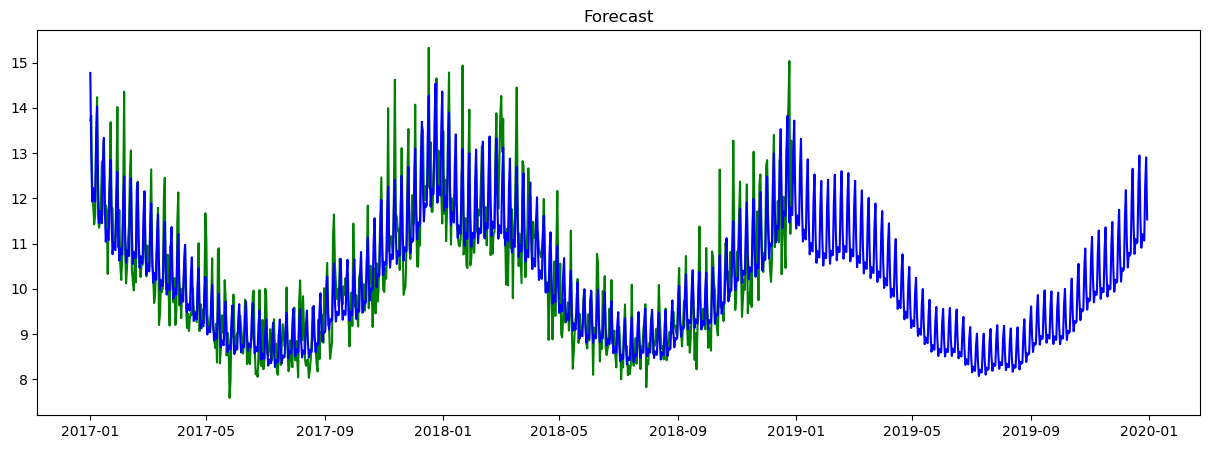

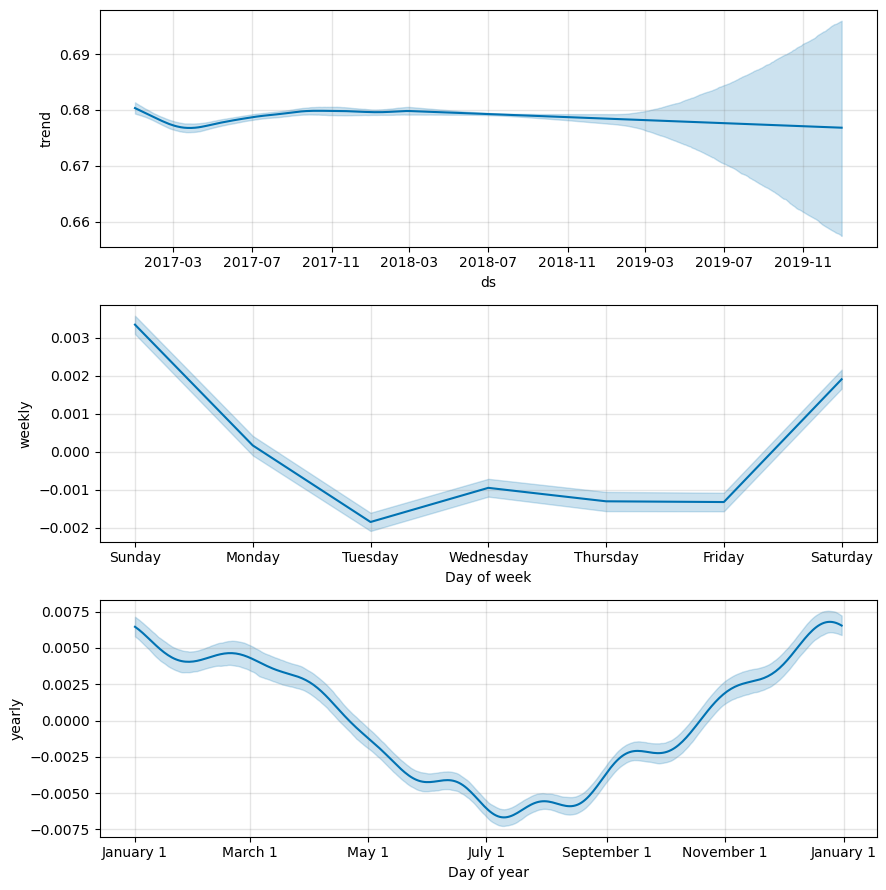

In [37]:
# Create a forecast for the next year
sme_full = student_energy_median.copy()
lm = lmbda

# Make a prediction
future = forecast_model.make_future_dataframe(
    periods=365, freq="D", include_history=True
)

forecast = forecast_model.predict(future)

forecast[["yhat", "yhat_upper", "yhat_lower"]] = forecast[
    ["yhat", "yhat_upper", "yhat_lower"]
].apply(lambda x: inv_boxcox(x, lm))
sme_full["y"] = inv_boxcox(sme_full["y"], lm)

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Forecast")
ax.plot(sme_full["ds"], sme_full["y"], color="green")
ax.plot(forecast["ds"], forecast["yhat"], color="blue")
plt.show()

_ = forecast_model.plot_components(forecast)
plt.show()

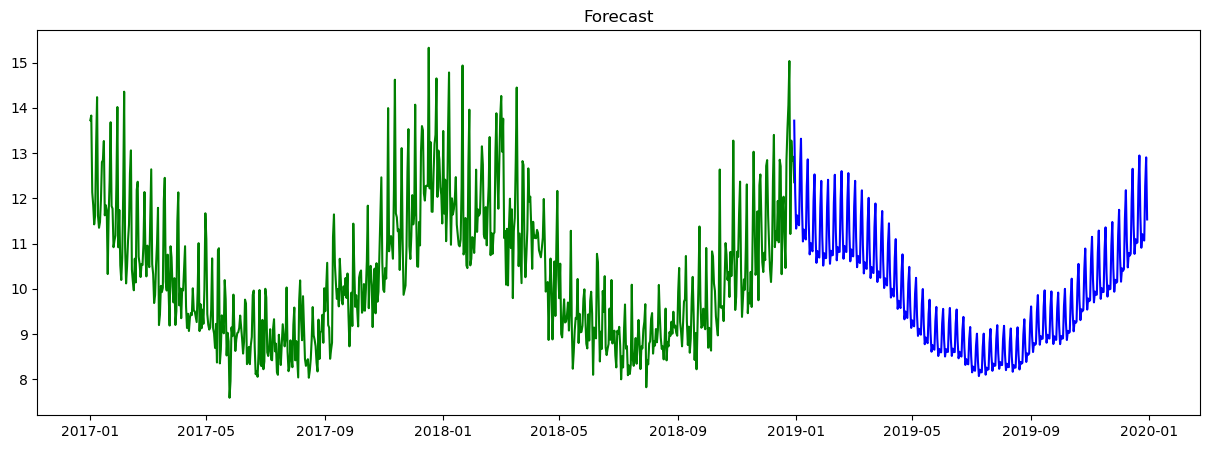

In [38]:
forecast_short = forecast[forecast["ds"] >= "2018-12-30"]

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Forecast")
ax.plot(sme_full["ds"], sme_full["y"], color="green")
ax.plot(forecast_short["ds"], forecast_short["yhat"], color="blue")
plt.show()

In [39]:
# Export the prediction results

forecast.to_csv(
    "../models/results/median_forecast.csv",
    index=False,
)

## Random subsample forecasting

- The above median usage allows us to understand the overall energy consumption of all student households over the years 2017 and 2018. It also allows us to forecast the energy consumption for 2019.
- In this section, we understand the energy consumption of 5 random subsamples.
    - Each household uses the median of all student households as an indicator, along with its own energy use.
    - This allows us to understand and forecast energy use for specific students
    - This process will allow us to then forecast dependent factors for a specific household
- Together, both these forecasts provide an understanding of the energy use per household and in comparison to all households

15:24:24 - cmdstanpy - INFO - Chain [1] start processing
15:24:24 - cmdstanpy - INFO - Chain [1] done processing


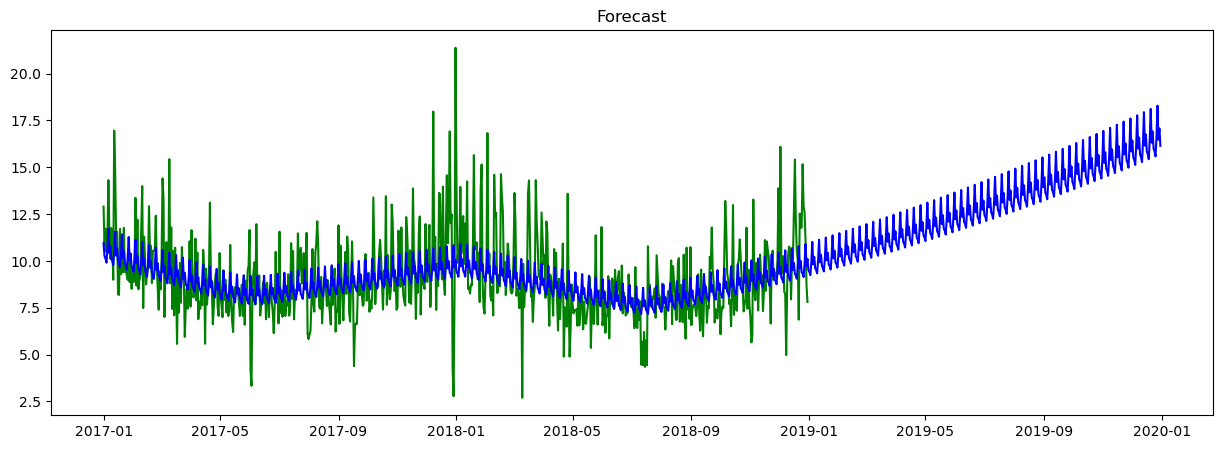

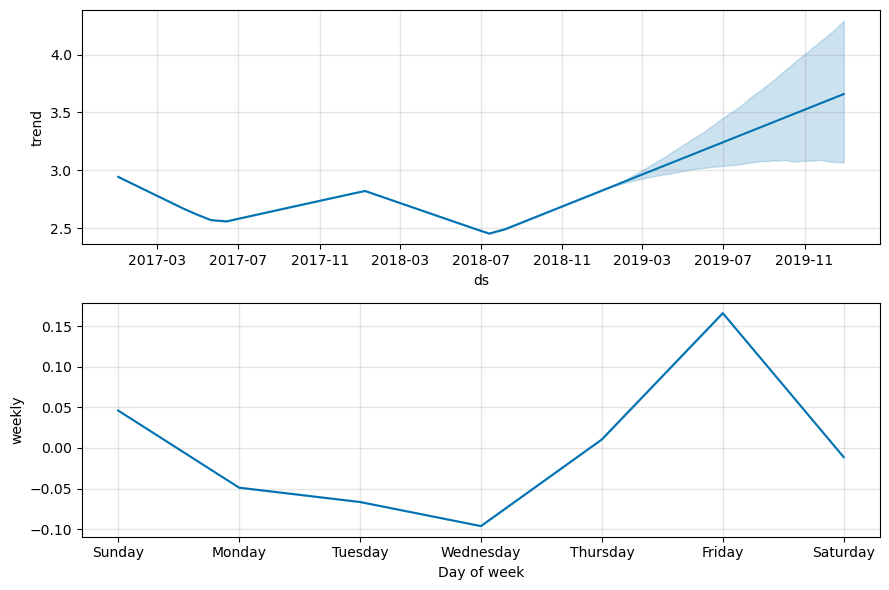

In [40]:
# Predict using tuned median model
sample_energy = student_energy_sample.copy()
sample_energy = student_energy_sample.drop("bmg_id", axis=1)
sample_energy = sample_energy.reset_index()
sample_energy = sample_energy.rename(
    columns={"recorded_timestamp": "ds", "energy": "y"}
)
sample_energy["y"], lam = boxcox(sample_energy["y"])


def warm_start_params(m):
    """
    Retrieve parameters from a trained model in the format used to initialise a new Stan model.
    Note that the new Stan model must have these same settings:
        n_changepoints, seasonality features, mcmc sampling
    for the retrieved parameters to be valid for the new model.

    Parameters
    ----------
    m: A trained model of the Prophet class.

    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    """
    res = {}
    for pname in ["k", "m", "sigma_obs"]:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0][0]
        else:
            res[pname] = np.mean(m.params[pname])
    for pname in ["delta", "beta"]:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0]
        else:
            res[pname] = np.mean(m.params[pname], axis=0)
    return res


# Refit to student energy data
sample_model = Prophet().fit(sample_energy, init=warm_start_params(forecast_model))

# Make a prediction
future = sample_model.make_future_dataframe(
    periods=365, freq="D", include_history=True
)

forecast = sample_model.predict(future)

forecast[["yhat", "yhat_upper", "yhat_lower"]] = forecast[
    ["yhat", "yhat_upper", "yhat_lower"]
].apply(lambda x: inv_boxcox(x, lam))
sample_energy["y"] = inv_boxcox(sample_energy["y"], lam)

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Forecast")
ax.plot(sample_energy["ds"], sample_energy["y"], color="green")
ax.plot(forecast["ds"], forecast["yhat"], color="blue")
plt.show()

_ = sample_model.plot_components(forecast)
plt.show()

In [41]:
sample_energy = student_energy_sample.copy()
sample_energy = student_energy_sample.drop("bmg_id", axis=1)
sample_energy = sample_energy.reset_index()
sample_energy = sample_energy.rename(
    columns={"recorded_timestamp": "ds", "energy": "y"}
)

sample_energy["y"], sample_lmbda = boxcox(sample_energy["y"])

client.cluster.scale(4)

train = sample_energy[sample_energy["ds"] < "10-01-2018"]
validate = sample_energy[sample_energy["ds"] >= "10-01-2018"]

param_space = dict(
    n_changepoints=range(0, 100, 5),
    changepoint_range=uniform(0.5, 0.5),
    seasonality_prior_scale=uniform(1, 10.0),
    changepoint_prior_scale=uniform(0.0, 1),
    interval_width=uniform(0.8, 0.15),
    monthly_seasonality=[True, False],
)


def parameter_tuning(args_list):
    global train, validate

    params_evaluated = []
    results = []

    for params in args_list:
        try:
            model_params = params.copy()
            model_params.pop("monthly_seasonality")
            model = Prophet(
                **model_params,
                daily_seasonality=False,
                growth="linear",
                seasonality_mode="additive",
                yearly_seasonality=True,
            )
            model.add_seasonality(name="weekly", period=7, fourier_order=2)
            if params["monthly_seasonality"]:
                model.add_seasonality(
                    name="monthly", period=30.5, fourier_order=3
                )
            model.add_seasonality(name="yearly", period=365, fourier_order=10)
            model.fit(train)
            forecast = model.predict(validate)
            error = root_mean_squared_error(validate["y"], forecast["yhat"])
            params_evaluated.append(params)
            results.append(error)
        except:
            params_evaluated.append(params)
            results.append(25.0)

    return params_evaluated, results


def early_stop(result):
    return result["best_objective"] <= 0.0005


conf_Dict = dict()
conf_Dict["early_stopping"] = early_stop
conf_Dict["initial_random"] = 15
conf_Dict["num_iteration"] = 200

tuner = Tuner(param_space, parameter_tuning, conf_Dict)
results = tuner.minimize()
print("best parameters:", results["best_params"])
print("best loss:", results["best_objective"])

best_params = results["best_params"]
tuned_model_params = best_params.copy()
tuned_model_params.pop("monthly_seasonality")
tuned_sample_model = Prophet(
    **tuned_model_params,
    daily_seasonality=False,
    yearly_seasonality=True,
    growth="linear",
    seasonality_mode="additive",
    uncertainty_samples=2000,
    mcmc_samples=500,
)
tuned_sample_model.add_seasonality(name="weekly", period=7, fourier_order=2)
if best_params["monthly_seasonality"]:
    tuned_sample_model.add_seasonality(
        name="monthly", period=30.5, fourier_order=3
    )
tuned_sample_model.add_seasonality(name="yearly", period=365, fourier_order=10)
tuned_sample_model.fit(
    sample_energy,
)

15:25:11 - cmdstanpy - INFO - Chain [1] start processing
15:25:11 - cmdstanpy - INFO - Chain [1] done processing
15:25:11 - cmdstanpy - INFO - Chain [1] start processing
15:25:11 - cmdstanpy - INFO - Chain [1] done processing
15:25:11 - cmdstanpy - INFO - Chain [1] start processing
15:25:11 - cmdstanpy - INFO - Chain [1] done processing
15:25:11 - cmdstanpy - INFO - Chain [1] start processing
15:25:11 - cmdstanpy - INFO - Chain [1] done processing
15:25:12 - cmdstanpy - INFO - Chain [1] start processing
15:25:12 - cmdstanpy - INFO - Chain [1] done processing
15:25:12 - cmdstanpy - INFO - Chain [1] start processing
15:25:12 - cmdstanpy - INFO - Chain [1] done processing
15:25:12 - cmdstanpy - INFO - Chain [1] start processing
15:25:12 - cmdstanpy - INFO - Chain [1] done processing
15:25:12 - cmdstanpy - INFO - Chain [1] start processing
15:25:12 - cmdstanpy - INFO - Chain [1] done processing
15:25:12 - cmdstanpy - INFO - Chain [1] start processing
15:25:12 - cmdstanpy - INFO - Chain [1]

best parameters: {'changepoint_prior_scale': np.float64(0.5696401976830296), 'changepoint_range': np.float64(0.8497859841057307), 'interval_width': np.float64(0.9060423134622185), 'monthly_seasonality': True, 'n_changepoints': 45, 'seasonality_prior_scale': np.float64(2.7088995578188326)}
best loss: 0.33918593058208335


chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 4 |                                                         | 00:00 Status


chain 1 |███████▍                  | 00:08 Iteration:   1 / 500 [  0%]  (Warmup)
chain 2 |███████▍                  | 00:08 Iteration:   1 / 500 [  0%]  (Warmup)

chain 1 |███████████▏              | 00:19 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 4 |███████████▏              | 00:19 Iteration: 100 / 500 [ 20%]  (Warmup)
chain 2 |███████████▏              | 00:19 Iteration: 100 / 500 [ 20%]  (Warmup)

chain 1 |██████████████▊           | 00:24 Iteration: 200 / 500 [ 40%]  (Warmup)
chain 2 |██████████████▊           | 00:24 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 4 |██████████████▊           | 00:24 Iteration: 200 / 500 [ 40%]  (Warmup)

chain 1 |███████


15:37:41 - cmdstanpy - INFO - CmdStan done processing.
15:37:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to 

In [42]:
print(tuned_sample_model.stan_fit.diagnose())

Processing csv files: /tmp/tmpxajmv_o4/prophet_modelkd6z6p7t/prophet_model-20250903153644_1.csv, /tmp/tmpxajmv_o4/prophet_modelkd6z6p7t/prophet_model-20250903153644_2.csv, /tmp/tmpxajmv_o4/prophet_modelkd6z6p7t/prophet_model-20250903153644_3.csv, /tmp/tmpxajmv_o4/prophet_modelkd6z6p7t/prophet_model-20250903153644_4.csv

Checking sampler transitions treedepth.
1000 of 1000 (100.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  m, delta[14], delta[16], delta[17], delta[36], delta[43], beta[11], beta[12], trend[1], trend[2], trend[3], trend[4], trend[5], trend[6],

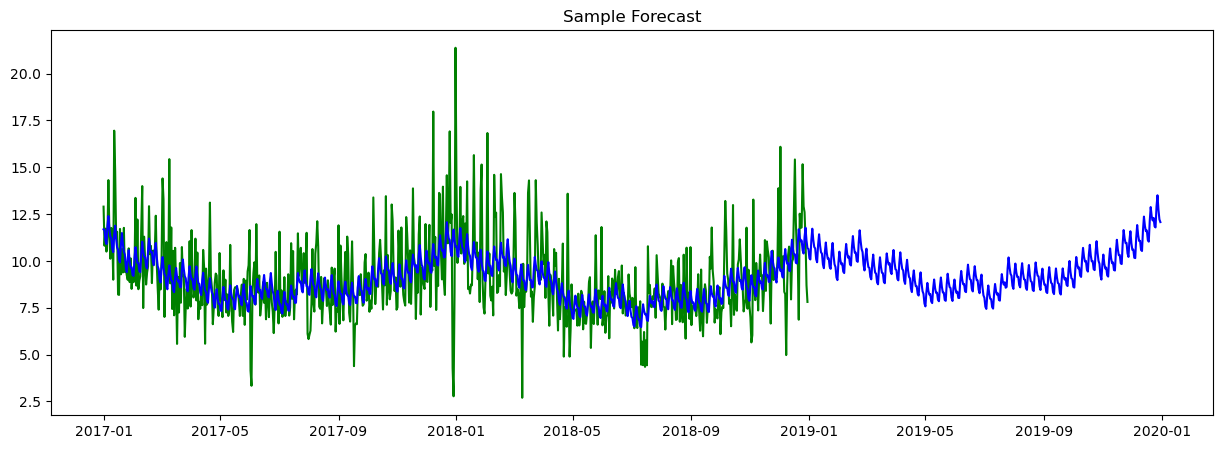

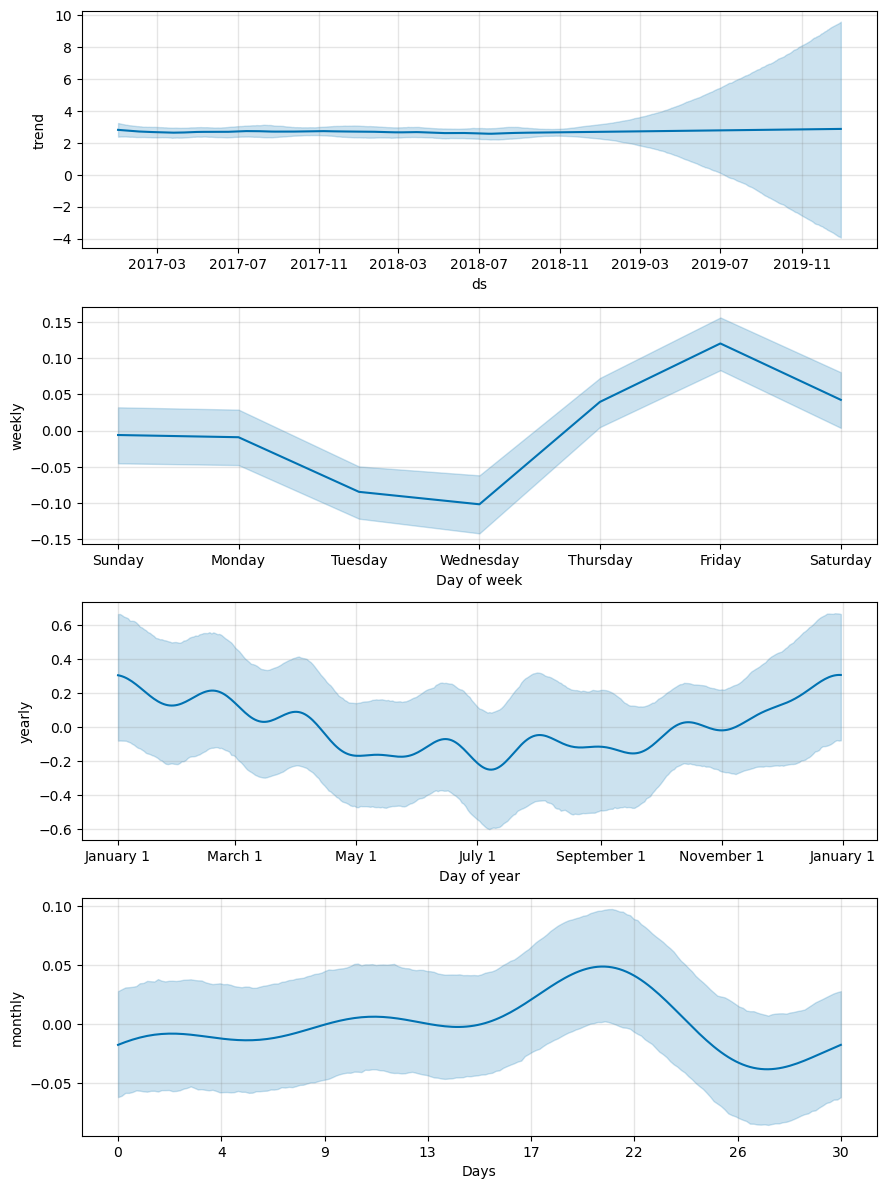

In [43]:
# Create a forecast for the next year

# Make a prediction
future = tuned_sample_model.make_future_dataframe(
    periods=365, freq="D", include_history=True
)

sample_forecast = tuned_sample_model.predict(future)

sample_forecast[["yhat", "yhat_upper", "yhat_lower"]] = sample_forecast[
    ["yhat", "yhat_upper", "yhat_lower"]
].apply(lambda x: inv_boxcox(x, sample_lmbda))
sample_energy["y"] = inv_boxcox(sample_energy["y"], sample_lmbda)

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Sample Forecast")
ax.plot(sample_energy["ds"], sample_energy["y"], color="green")
ax.plot(sample_forecast["ds"], sample_forecast["yhat"], color="blue")
plt.show()

_ = tuned_sample_model.plot_components(sample_forecast)
plt.show()

In [44]:
# Export tuned model
# Save the model
with open(
    "../models/sample_"
    + random_id
    + "_noreg.json",
    "w",
) as fout:
    fout.write(model_to_json(tuned_sample_model))

In [45]:
# Export the prediction results

sample_forecast.to_csv(
    "../models/results/sample_"
    + random_id
    + "_forecast_noreg.csv",
    index=False,
)

### Using Median Energy as a factor

In [46]:
median_regressor = pd.read_csv(
    "../models/results/median_forecast.csv",
    usecols=["ds", "yhat"],
)
median_regressor = median_regressor.rename({'yhat': 'y_median'}, axis=1)
median_regressor["ds"] = pd.to_datetime(median_regressor["ds"])
sample_energy = student_energy_sample.copy()
sample_energy = student_energy_sample.drop("bmg_id", axis=1)
sample_energy = sample_energy.reset_index()
sample_energy = sample_energy.rename(
    columns={"recorded_timestamp": "ds", "energy": "y"}
)

sample_energy["y"], sample_lmbda = boxcox(sample_energy["y"])
median_regressor["y_median"] = boxcox(median_regressor["y_median"], sample_lmbda)

sample_energy = pd.merge(sample_energy, median_regressor, on="ds", how="left")


client.cluster.scale(4)

train = sample_energy[sample_energy["ds"] < "10-01-2018"]
validate = sample_energy[(sample_energy["ds"] >= "10-01-2018") & (sample_energy["ds"] < "30-12-2018")]

param_space = dict(
    n_changepoints=range(0, 100, 5),
    changepoint_range=uniform(0.5, 0.5),
    seasonality_prior_scale=uniform(1, 10.0),
    changepoint_prior_scale=uniform(0.0, 1),
    interval_width=uniform(0.8, 0.15),
    monthly_seasonality=[True, False],
)


def parameter_tuning(args_list):
    global train, validate

    params_evaluated = []
    results = []

    for params in args_list:
        try:
            model_params = params.copy()
            model_params.pop("monthly_seasonality")
            model = Prophet(
                **model_params,
                daily_seasonality=False,
                growth="linear",
                seasonality_mode="additive",
                yearly_seasonality=True,
            )
            model.add_seasonality(name="weekly", period=7, fourier_order=2)
            if params["monthly_seasonality"]:
                model.add_seasonality(
                    name="monthly", period=30.5, fourier_order=3
                )
            model.add_seasonality(name="yearly", period=365, fourier_order=10)
            model.add_regressor("y_median")
            model.fit(train)
            forecast = model.predict(validate)
            error = root_mean_squared_error(validate["y"], forecast["yhat"])
            params_evaluated.append(params)
            results.append(error)
        except:
            params_evaluated.append(params)
            results.append(25.0)

    return params_evaluated, results


def early_stop(result):
    return result["best_objective"] <= 0.0005


conf_Dict = dict()
conf_Dict["early_stopping"] = early_stop
conf_Dict["initial_random"] = 15
conf_Dict["num_iteration"] = 200

tuner = Tuner(param_space, parameter_tuning, conf_Dict)
results = tuner.minimize()
print("best parameters:", results["best_params"])
print("best loss:", results["best_objective"])

best_params = results["best_params"]
tuned_model_params = best_params.copy()
tuned_model_params.pop("monthly_seasonality")
tuned_sample_model = Prophet(
    **tuned_model_params,
    daily_seasonality=False,
    yearly_seasonality=True,
    growth="linear",
    seasonality_mode="additive",
    uncertainty_samples=2000,
    mcmc_samples=500,
)
tuned_sample_model.add_seasonality(name="weekly", period=7, fourier_order=2)
if best_params["monthly_seasonality"]:
    tuned_sample_model.add_seasonality(
        name="monthly", period=30.5, fourier_order=3
    )
tuned_sample_model.add_seasonality(name="yearly", period=365, fourier_order=10)
tuned_sample_model.add_regressor("y_median")
tuned_sample_model.fit(
    sample_energy,
)

15:37:45 - cmdstanpy - INFO - Chain [1] start processing
15:37:45 - cmdstanpy - INFO - Chain [1] done processing
15:37:45 - cmdstanpy - INFO - Chain [1] start processing
15:37:45 - cmdstanpy - INFO - Chain [1] done processing
15:37:45 - cmdstanpy - INFO - Chain [1] start processing
15:37:45 - cmdstanpy - INFO - Chain [1] done processing
15:37:45 - cmdstanpy - INFO - Chain [1] start processing
15:37:45 - cmdstanpy - INFO - Chain [1] done processing
15:37:45 - cmdstanpy - INFO - Chain [1] start processing
15:37:45 - cmdstanpy - INFO - Chain [1] done processing
15:37:46 - cmdstanpy - INFO - Chain [1] start processing
15:37:46 - cmdstanpy - INFO - Chain [1] done processing
15:37:46 - cmdstanpy - INFO - Chain [1] start processing
15:37:46 - cmdstanpy - INFO - Chain [1] done processing
15:37:46 - cmdstanpy - INFO - Chain [1] start processing
15:37:46 - cmdstanpy - INFO - Chain [1] done processing
15:37:46 - cmdstanpy - INFO - Chain [1] start processing
15:37:46 - cmdstanpy - INFO - Chain [1]

best parameters: {'changepoint_prior_scale': np.float64(0.4104395250852827), 'changepoint_range': np.float64(0.6741388231097458), 'interval_width': np.float64(0.8094890813699224), 'monthly_seasonality': True, 'n_changepoints': 40, 'seasonality_prior_scale': np.float64(9.0587336466505)}
best loss: 0.3375598288396922


chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 4 |                                                         | 00:00 Status

chain 1 |███████▍                  | 00:08 Iteration:   1 / 500 [  0%]  (Warmup)
chain 2 |███████▍                  | 00:08 Iteration:   1 / 500 [  0%]  (Warmup)


chain 4 |███████▍                  | 00:09 Iteration:   1 / 500 [  0%]  (Warmup)

chain 3 |███████████▏              | 00:18 Iteration: 100 / 500 [ 20%]  (Warmup)
chain 1 |███████████▏              | 00:19 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 4 |███████████▏              | 00:19 Iteration: 100 / 500 [ 20%]  (Warmup)

chain 3 |██████████████▊           | 00:23 Iteration: 200 / 500 [ 40%]  (Warmup)
chain 1 |██████████████▊           | 00:25 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 4 |███████


15:51:46 - cmdstanpy - INFO - CmdStan done processing.
15:51:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, 

In [47]:
print(tuned_sample_model.stan_fit.diagnose())

Processing csv files: /tmp/tmpxajmv_o4/prophet_model7sk2l3t_/prophet_model-20250903155049_1.csv, /tmp/tmpxajmv_o4/prophet_model7sk2l3t_/prophet_model-20250903155049_2.csv, /tmp/tmpxajmv_o4/prophet_model7sk2l3t_/prophet_model-20250903155049_3.csv, /tmp/tmpxajmv_o4/prophet_model7sk2l3t_/prophet_model-20250903155049_4.csv

Checking sampler transitions treedepth.
1000 of 1000 (100.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  m, delta[40], beta[1], beta[2], beta[3], beta[12], beta[14], beta[31], trend[1], trend[2], trend[3], trend[4], trend[5], trend[6], trend[

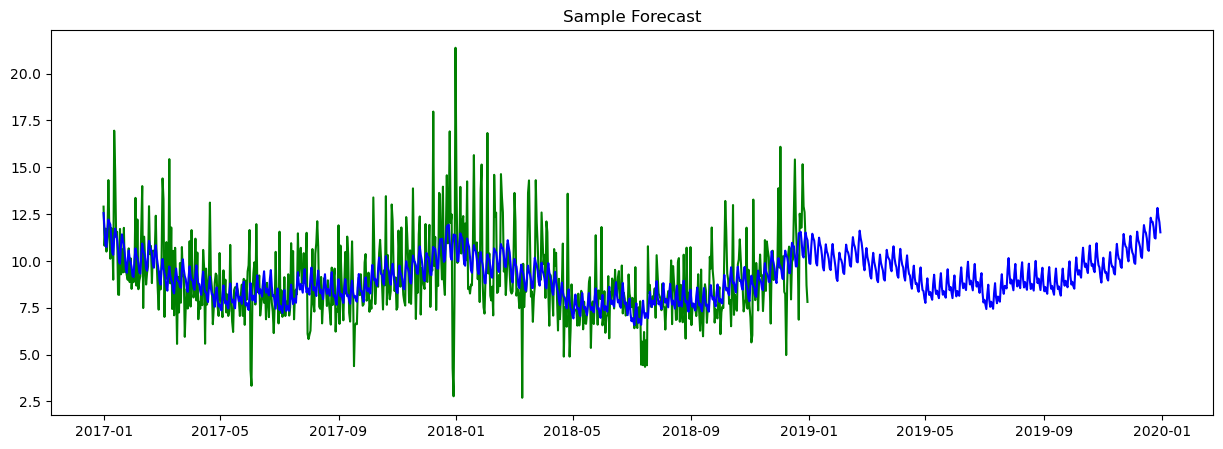

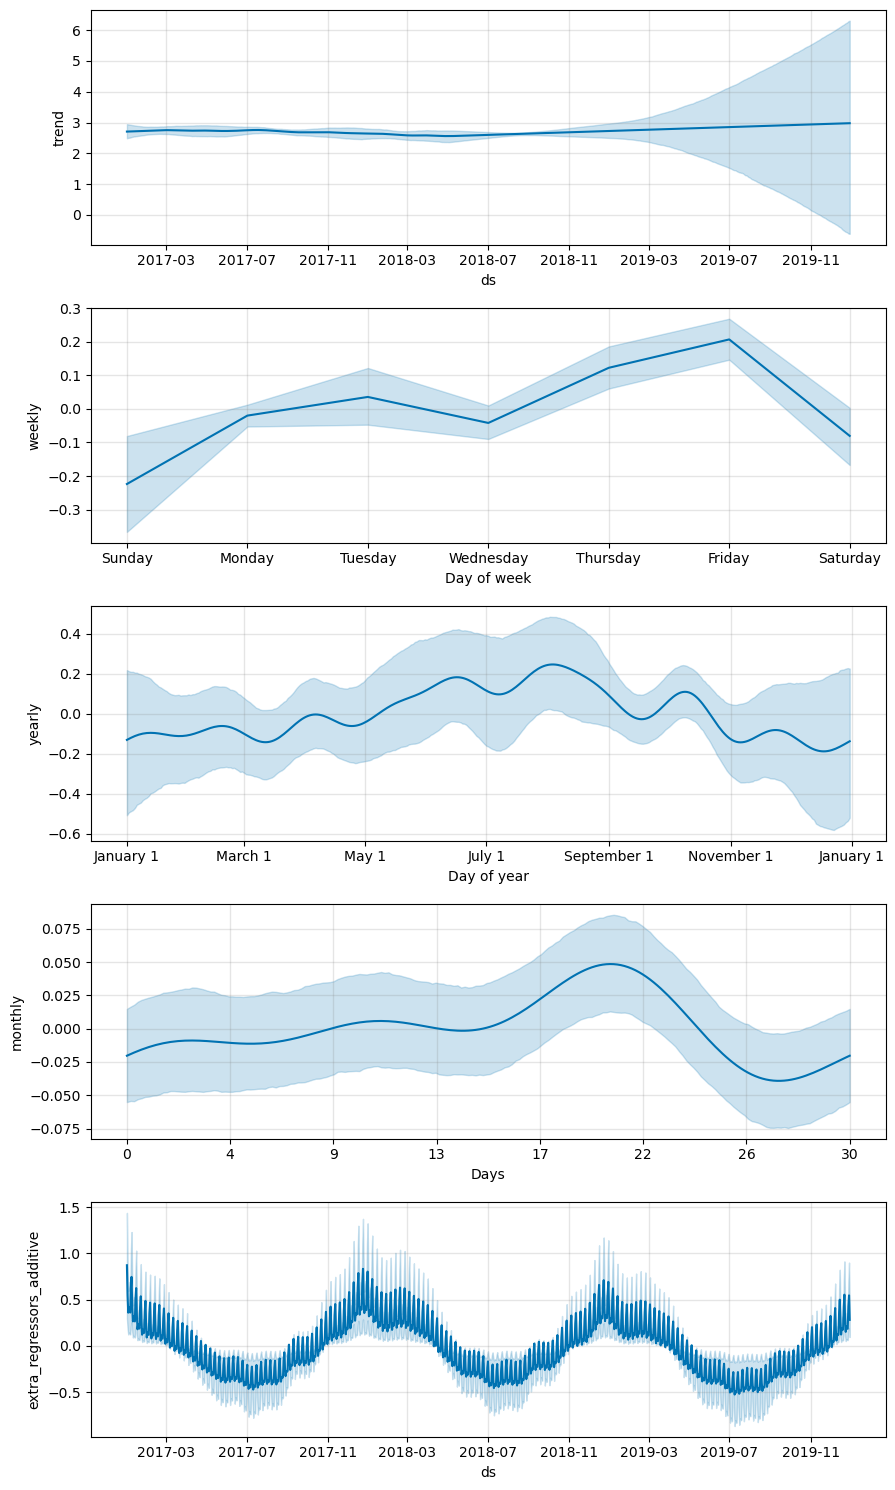

In [48]:
# Create a forecast for the next year

# Make a prediction
future = tuned_sample_model.make_future_dataframe(
    periods=365, freq="D", include_history=True
)
future['y_median'] = median_regressor['y_median']

sample_forecast = tuned_sample_model.predict(future)

sample_forecast[["yhat", "yhat_upper", "yhat_lower"]] = sample_forecast[
    ["yhat", "yhat_upper", "yhat_lower"]
].apply(lambda x: inv_boxcox(x, sample_lmbda))
sample_energy["y"] = inv_boxcox(sample_energy["y"], sample_lmbda)

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Sample Forecast")
ax.plot(sample_energy["ds"], sample_energy["y"], color="green")
ax.plot(sample_forecast["ds"], sample_forecast["yhat"], color="blue")
plt.show()

_ = tuned_sample_model.plot_components(sample_forecast)
plt.show()

In [50]:
# Export tuned model
# Save the model
with open(
    "../models/sample_"
    + random_id
    + "_with_reg.json",
    "w",
) as fout:
    fout.write(model_to_json(tuned_sample_model))

In [51]:
# Export the prediction results

sample_forecast.to_csv(
    "../models/results/sample_"
    + random_id
    + "_forecast_with_reg.csv",
    index=False,
)

In [53]:
client.shutdown()